# Attention readout and visualisation

In [66]:
# this file uses the environment called attentionviz2

In [2]:

import os
import sys
from rdkit import Chem
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit.Chem import rdmolops
from rdkit import RDConfig
#plotting
from IPython.display import SVG
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from collections import namedtuple
import torch
from IPython.display import SVG
from IPython.display import Image, display
import io
import numpy as np
import re
import sys
from pathlib import Path
import matplotlib.pyplot as plt
from itertools import cycle
from scipy.stats import ttest_rel


In [3]:
#to import to get attention from model
import sys
sys.path.append('/home/ifender/SOS/SMILES_or_SELFIES/attention_visualized')
from attention_readout import gather_attention
from constants import PREDICTION_MODEL_PATH, TASK_MODEL_PATH, PARSING_REGEX, MOLNET_DIRECTORY
# PREDICTION_MODEL_PATH = Path("/data/jgut/SMILES_or_SELFIES/prediction_models") --> pretrained models
# TASK_MODEL_PATH = Path("/data2/jgut/SoS_models/") --> finetuned models

/home/ifender/miniconda3/envs/attentionviz2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (/home/ifender/miniconda3/envs/attentionviz2/lib/python3.10/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'pytorch_lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'
2025-01-22 10:04:44 | INFO | fairseq.tasks.text_to_speech | Pl

In [4]:
sys.path.insert(0,'/home/ifender/SOS/SMILES_or_SELFIES/atomtype_embedding_visualisation')
from atomtype_embedding_assignment import load_molnet_test_set, canonize_smiles, get_tokenized_SMILES, load_assignments_from_folder, create_elementsubsets
from SMILES_to_SELFIES_mapping import generate_mapping, generate_mappings_for_task_SMILES_to_SELFIES

## Functions

In [5]:
def clean_SMILES(SMILES_tok):
    """Removing structural tokens, hydrogens, and numbers from SMILES token input

    Args:
        SMILES_tok (_list_): List of SMILES_tokens for a given SMILES

    Returns:
        _list,list_: Processed SMILES_token list and list of positions in input tokens list that were kept
        (needed to distinguish which embeddings are relevant)
    """
    SMILES_tok_prep = list()
    struc_toks = r"()=:~1234567890#"
    posToKeep = list()
    pos = 0
    for i in range(len(SMILES_tok)):
        # when it's an H in the SMILES, ignore, cannot deal
        if SMILES_tok[i] != "H" and SMILES_tok[i] != "h" and not SMILES_tok[i].isdigit() and not SMILES_tok[i].isspace():
            if any(elem in struc_toks for elem in SMILES_tok[i]) == False:
                if SMILES_tok[i] != "-":
                    SMILES_tok_prep.append(SMILES_tok[i])
                    # keep pos where you keep SMILES token
                    posToKeep.append(pos)
        pos += 1
    assert(len(posToKeep) == (len(SMILES_tok_prep))
           ), f"Length of positions-to-keep-array ({len(posToKeep)}) and length of SMILES_tok_prep ({len(SMILES_tok_prep)}) are not the same"
    print("SMILES_tok: ", SMILES_tok)
    print("posToKeep: ", posToKeep)
    print("SMILES_tok_prep: ", SMILES_tok_prep)

    return SMILES_tok_prep, posToKeep


In [6]:

def cleanAndNormalizeAttention(attention_array,posToKeep,clean_smiles):
    # filter attention tensor according to posToKeep to only keep attention for non-hydrogen atoms
    filtered_attentions = attention_array[posToKeep]
    print(len(filtered_attentions))
    assert len(clean_smiles)==len(filtered_attentions), "Assert failed"
    # condense attention depending on method chosen
    mean_values = np.mean(filtered_attentions)
    min_val = np.min(filtered_attentions)
    max_val = np.max(filtered_attentions)
    normalized_means = (filtered_attentions - min_val) / (max_val - min_val)
    print("before normalisation: ",filtered_attentions)
    print("normalized means where all values fall between 0 and 1: ",normalized_means)
    return normalized_means



In [7]:
def norm_attention(attentions):
    min_val = np.min(attentions)
    max_val = np.max(attentions)
    normalized_means = (attentions - min_val) / (max_val - min_val)
    return normalized_means

In [8]:
def drawMoleculeWithAttention(orig_smiles,clean_smiles,norm_attentions):

    # Generate a color map from 0-1 scaled to attentions
    min_val = norm_attentions.min()
    max_val = norm_attentions.max()
    print(f"Minimum and maximum attention values: {min_val}, {max_val}")
    norm = mcolors.Normalize(vmin=min_val, vmax=max_val)
    scalar_map = plt.cm.ScalarMappable(norm=norm, cmap='viridis')

    mol = Chem.MolFromSmiles(orig_smiles)
    drawer = rdMolDraw2D.MolDraw2DCairo(300, 300)
    mol_with_style = rdMolDraw2D.PrepareMolForDrawing(mol, kekulize=False)

    # Set the drawing options
    opts = drawer.drawOptions()

    # Create a color map for the atoms
    atom_colors = {i: scalar_map.to_rgba(norm_attentions[i])[:-1] for i in range(mol.GetNumAtoms())}  # Remove alpha channel

    # Draw the molecule with colored atoms according to attention scores
    AllChem.Compute2DCoords(mol)
    d = rdMolDraw2D.MolDraw2DSVG(400, 400)
    rdMolDraw2D.PrepareAndDrawMolecule(d, mol, highlightAtoms=range(mol.GetNumAtoms()),
                                      highlightAtomColors=atom_colors)

    d.FinishDrawing()
    # get the SVG string
    svg = d.GetDrawingText()
    # fix the svg string and display it
    display(SVG(svg.replace('svg:','')))

    # Colorbar
    plt.figure(figsize=(4.5, 0.5))
    img = np.array([[min_val, max_val]])
    plt.imshow(img, cmap='viridis')
    plt.gca().set_visible(False)
    cax = plt.axes([0.1, 0.2, 0.8, 0.6])
    colba = plt.colorbar(cax=cax, orientation="horizontal")
    colba.set_label('Attention Score')
    plt.savefig("test.png")
    plt.show()

In [9]:
def colorAtomsByAttention(smiles):
    #tokenize, only atomwise supported
    #smiles_tok = re.findall(r'Cl|.', smiles)
    smiles_tok = [elem for elem in re.split(PARSING_REGEX,smiles) if elem]
    clean_smiles,posToKeep = clean_SMILES(smiles_tok)
    # get attention from model, only BART for now
    attention = gather_attention(smiles,
                 smiles_atom_path=PREDICTION_MODEL_PATH/"smiles_atom_isomers_bart"/"checkpoint_last.pt",
                 smiles_sentencepiece_path=PREDICTION_MODEL_PATH/"smiles_trained_isomers_bart"/"checkpoint_last.pt",
                 selfies_atom_path=PREDICTION_MODEL_PATH/"selfies_atom_isomers_bart"/"checkpoint_last.pt",
                 selfies_sentencepiece_path=PREDICTION_MODEL_PATH/"selfies_trained_isomers_bart"/"checkpoint_last.pt")
    # remove attention on hydrogens, numbers, structural tokens and minmax normalize attention to values between 0 and 1
    norm_attention = cleanAndNormalizeAttention(attention,posToKeep,clean_smiles)
    # draw molecule with colored atoms according to attention scores
    drawMoleculeWithAttention(smiles,clean_smiles,norm_attention)

In [10]:
def gather_attention_for_manySMILES(task_smiles):
    # PREDICTION_MODEL_PATH = Path("/data/jgut/SMILES_or_SELFIES/prediction_models") --> pretrained models
    TASK_MODEL_PATH = Path("/data2/jgut/SoS_models/") #--> finetuned models
    atts = {}
    for smiles in task_smiles:
        #print(smiles)
        atts[smiles] = {}
        smiles_attention_bart_pretrained, selfies_attention_bart_pretrained = gather_attention(smiles,
                 smiles_atom_path=PREDICTION_MODEL_PATH/"smiles_atom_isomers_bart"/"checkpoint_last.pt",
                 smiles_sentencepiece_path=PREDICTION_MODEL_PATH/"smiles_trained_isomers_bart"/"checkpoint_last.pt",
                 selfies_atom_path=PREDICTION_MODEL_PATH/"selfies_atom_isomers_bart"/"checkpoint_last.pt",
                 selfies_sentencepiece_path=PREDICTION_MODEL_PATH/"selfies_trained_isomers_bart"/"checkpoint_last.pt")
        smiles_attention_bart_finetuned, selfies_attention_bart_finetuned = gather_attention(smiles,
                 smiles_atom_path=TASK_MODEL_PATH/"delaney"/"smiles_atom_isomers_bart"/"1e-05_0.2_seed_0"/"checkpoint_best.pt",
                 smiles_sentencepiece_path=TASK_MODEL_PATH/"delaney"/"smiles_trained_isomers_bart"/"5e-05_0.2_seed_0"/"checkpoint_best.pt",
                 selfies_atom_path=TASK_MODEL_PATH/"delaney"/"selfies_atom_isomers_bart"/"1e-05_0.2_seed_0"/"checkpoint_best.pt", # previously PREDICTION_MODEL_PATH/"selfies_atom_isomers_bart"/"checkpoint_last.pt",
                 selfies_sentencepiece_path=TASK_MODEL_PATH/"delaney"/"selfies_trained_isomers_bart"/"5e-05_0.2_seed_0"/"checkpoint_best.pt") # previously PREDICTION_MODEL_PATH/"selfies_trained_isomers_bart"/"checkpoint_last.pt")
        atts[smiles]['attention_bart_pretrained']=smiles_attention_bart_pretrained
        atts[smiles]['attention_bart_finetuned']=smiles_attention_bart_finetuned
        atts[smiles]['attention_bart_pretrained_selfies']=selfies_attention_bart_pretrained
        atts[smiles]['attention_bart_finetuned_selfies']=selfies_attention_bart_finetuned
        print("smiles: ",smiles)
        print("attention bart pretrained: ",smiles_attention_bart_pretrained)
        #print("atention bart pretrained: ",attention_bart_pretrained)
        #print("attention bart finetuned: ",attention_bart_finetuned)
    return atts

In [11]:
def add_clean_att_and_normatt_into_dikt(dikt,smiles_to_att_dict,smiles_dict):
    #dict_keys(['posToKeep', 'smi_clean', 'atom_types', 'max_penalty'])
    atomtypes_to_two_attentions={}
    for key, val in dikt.items():
        atomtypes_to_two_attentions[key]=[]
        dikt[key]['attention_bart_pretrained']={}
        dikt[key]['attention_bart_finetuned']={}
        if dikt[key]['posToKeep']!=None:
            #print(key)
            posToKeeplist = dikt[key]['posToKeep']
            assert key in smiles_to_att_dict, "key not in smiles_to_att_dict"
            assert len(smiles_dict[key])==len(smiles_to_att_dict[key]['attention_bart_pretrained']), f"length of tokenized smiles in smiles dict ({len(smiles_dict[key])}) and smiles_to_att_dict pretrained ({len(smiles_to_att_dict[key]['attention_bart_pretrained'])}) not equal"
            assert len(smiles_dict[key])==len(smiles_to_att_dict[key]['attention_bart_finetuned']), f"length of tokenized smiles in smiles dict ({len(smiles_dict[key])}) and smiles_to_att_dict finetuned ({len(smiles_to_att_dict[key]['attention_bart_finetuned'])}) not equal"
            
            # for pretrained
            it='attention_bart_pretrained'
            clean_atts_pre = [item for index, item in enumerate(smiles_to_att_dict[key][it]) if index in posToKeeplist]
            #print(dikt[key]['atom_types'])
           # print("clean atts: ",clean_atts_pre)
            dikt[key][it]['raw_attention']=smiles_to_att_dict[key][it]
            dikt[key][it]['clean_attention']=clean_atts_pre
            dikt[key][it]['atomtype_to_clean_attention']=[(atype, clean_att) for atype, clean_att in zip(dikt[key]['atom_types'],clean_atts_pre)]
            norm_atts_pre = norm_attention(clean_atts_pre)
            #print("norm ats pre: ",norm_atts_pre)
            dikt[key][it]['atomtype_to_norm_attention']=[(atype, norm_att) for atype, norm_att in zip(dikt[key]['atom_types'],norm_atts_pre)]
           
            # for finetuned
            it='attention_bart_finetuned'
            clean_atts_fine = [item for index, item in enumerate(smiles_to_att_dict[key][it]) if index in posToKeeplist]
            #print(dikt[key]['atom_types'])
            #print("clean atts: ",clean_atts_fine)
            dikt[key][it]['raw_attention']=smiles_to_att_dict[key][it]
            dikt[key][it]['clean_attention']=clean_atts_fine
            dikt[key][it]['atomtype_to_clean_attention']=[(atype, clean_att) for atype, clean_att in zip(dikt[key]['atom_types'],clean_atts_fine)]
            norm_atts_fine = norm_attention(clean_atts_fine)
            #print("norm ats: ",norm_atts_fine)
            dikt[key][it]['atomtype_to_norm_attention']=[(atype, norm_att) for atype, norm_att in zip(dikt[key]['atom_types'],norm_atts_fine)]
            
        
            atomtype_to_clean_combined_atts = [(atype, [pre, fine]) for atype, pre, fine in zip(dikt[key]['atom_types'], clean_atts_pre, clean_atts_fine)]
            dikt[key]['atomtype_to_clean_atts_pre_fine'] = atomtype_to_clean_combined_atts
            atomtype_to_clean_normed_combined_atts = [(atype, [pre, fine]) for atype, pre, fine in zip(dikt[key]['atom_types'], norm_atts_pre, norm_atts_fine)]
            dikt[key]['atomtype_to_clean_minmaxnormed_atts_pre_fin'] = atomtype_to_clean_normed_combined_atts
            
        else:
                for it in ['attention_bart_pretrained','attention_bart_finetuned']:
                    dikt[key][it]['raw_attention']=None
                    dikt[key][it]['clean_attention']=None
                    dikt[key][it]['atomtype_to_clean_attention']=None
                    dikt[key][it]['atomtype_to_norm_attention']=None
                    dikt[key]['atomtype_to_clean_atts_pre_fine']=None
                    dikt[key]['atomtype_to_clean_minmaxnormed_atts_pre_fin']=None


In [12]:
def plotter_atomtypes_vs_attention_pretrained_finetuned(atomtypes,x_values,y_values,elementname,norm, save=False):
    
    # https://sashamaps.net/docs/resources/20-colors/ #95% accessible only, subject to change, no white
    colors_sash = ['#e6194B', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#42d4f4', '#f032e6', '#bfef45', '#fabed4',
                   '#469990', '#dcbeff', '#9A6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#a9a9a9', '#000000']
    colors_sash_moreaccess = ['#ffe119', '#4363d8', '#f58231', '#dcbeff', '#800000', '#000075', '#a9a9a9', '#000000']
    unique_atom_types = list(set(atomtypes))
    if len(unique_atom_types) > len(colors_sash_moreaccess):
        colors = colors_sash[:len(unique_atom_types)]
    elif len(unique_atom_types) == 1:
        colors = ['#000000']
    else:
        colors = colors_sash_moreaccess[:len(unique_atom_types)]
    #colors = plt.cm.jet(np.linspace(0, 1, len(unique_atom_types)))
    # Cycle through colors_sash if there are more unique_atom_types than colors available
    #color_cycle = cycle(colors_sash)
    
    color_map = dict(zip(unique_atom_types, colors))
    max_val=max(max(x_values),max(y_values))
    buffer = max_val * 0.05

    # only plot if atomtypes> 10, no need to plot anything smaller
    if len(atomtypes) >= 10:
        fig,ax = plt.subplots()
        # Plot each point, specifying its color based on atom type
        for atom_type, x, y in zip(atomtypes, x_values, y_values):
            plt.scatter(x, y, color=color_map[atom_type], label=atom_type)

        # Optional: Create a legend for the colors. This might create a large legend if there are many atom types.
        # To avoid repeating labels in the legend, we handle them separately
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))  # Removing duplicates
        ax.legend(by_label.values(), by_label.keys(),loc='center right', bbox_to_anchor=(1.5, 0.5),fontsize=17)

        ax.set_xlabel('Attention Finetuning',fontsize=17)
        ax.set_ylabel('Attention Pretraining',fontsize=17)
        ax.spines[['right', 'top']].set_visible(False)
        ax.spines["bottom"].set_linewidth(2)
        ax.spines["left"].set_linewidth(2)
        ax.tick_params(length=8, width=3, labelsize=15)
        ax.set_title(f'Attention on Atom Types of {elementname}',fontsize=21)
        ax.set_xlim(0, max_val+buffer)
        ax.set_ylim(0, max_val+buffer)
        plt.plot([0, max_val+buffer], [0, max_val+buffer], color='black', linestyle='--', linewidth=1)
        fig.show()
        if save:
            fig.savefig(f"./attention_prevsfine/{elementname}_{norm}_attention_pretrained_finetuned.svg",bbox_inches='tight')

In [13]:
def perform_paired_ttest(atomtypes,before_values,after_values):
    # Perform the paired t-test
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html 
    t_statistic, p_value = ttest_rel(before_values, after_values)
    print("t-statistic: calculated as (a-b)/stderror")
    print(f"T-statistic: {t_statistic}, P-value: {p_value}")

    # Interpret the p-value
    alpha = 0.05  # Common threshold for significance
    if p_value < alpha:
        print("Reject the null hypothesis - suggest the means are different")
        print("-----> average score differs significantly!")
    else:
        print("Fail to reject the null hypothesis - suggest the means are not different")
        
        
    # calculate paired t-test for each atom type seperately
    atomtype_set = set(atomtypes)
    for atomtype in atomtype_set:
        before_values_atomtype = [before_values[i] for i in range(len(atomtypes)) if atomtypes[i] == atomtype]
        after_values_atomtype = [after_values[i] for i in range(len(atomtypes)) if atomtypes[i] == atomtype]
        t_statistic, p_value = ttest_rel(before_values_atomtype, after_values_atomtype)
        print(f"\tAtom type: {atomtype} with {len(before_values_atomtype)} values")
        print(f"\tT-statistic: {t_statistic}, P-value: {p_value}")
        if p_value < alpha:
            print("\tReject the null hypothesis - suggest the means are different")
            print("\t-----> average score differs significantly!")
       #else:
        #    print("\tFail to reject the null hypothesis - suggest the means are not different")

## Main

### Get every molecule of Delaney dataset and their atom types

In [14]:
# get SMILES from task
task = "delaney"
#task = "bace_classification"
assert task in list(
    MOLNET_DIRECTORY.keys()
), f"{task} not in MOLNET tasks."

# get SMILES from task
task_SMILES, task_labels = load_molnet_test_set(task)
print(f"SMILES: {task_SMILES} \n len task_SMILES delaney: {len(task_SMILES)}")

# make sure all task SMILES are the canonical SMILES
task_SMILES = [canonize_smiles(smiles) for smiles in task_SMILES]

# get tokenized version of dataset, SMILES mapped to tokenised version
smiles_dict = get_tokenized_SMILES(task_SMILES)
    
# get atom assignments from folder that contains antechamber atom assignments and parmchk files
dikt, totalfails, failedSmiPos, posToKeep_list = load_assignments_from_folder("./../atomtype_embedding_visualisation/delaney_mols_bccc0_gaff2_assigned", smiles_dict, task_SMILES)

# generate mappin gs for SMILES to SELFIES
smiles_to_selfies_mapping = generate_mappings_for_task_SMILES_to_SELFIES(task_SMILES)
print(f"smiles_to_selfies_mapping: {smiles_to_selfies_mapping}")

2025-01-22 10:06:46 | INFO | deepchem.molnet.load_function.molnet_loader | About to featurize delaney dataset.
2025-01-22 10:06:47 | INFO | deepchem.data.data_loader | Loading raw samples now.
2025-01-22 10:06:47 | INFO | deepchem.data.data_loader | shard_size: 8192
2025-01-22 10:06:47 | INFO | deepchem.utils.data_utils | About to start loading CSV from /tmp/delaney-processed.csv
2025-01-22 10:06:47 | INFO | deepchem.utils.data_utils | Loading shard 1 of size 8192.
2025-01-22 10:06:47 | INFO | deepchem.data.data_loader | About to featurize shard.
2025-01-22 10:06:47 | INFO | deepchem.feat.base_classes | Featurizing datapoint 0
2025-01-22 10:06:47 | INFO | deepchem.feat.base_classes | Featurizing datapoint 1000
2025-01-22 10:06:47 | INFO | deepchem.data.data_loader | TIMING: featurizing shard 0 took 0.345 s
2025-01-22 10:06:47 | INFO | deepchem.data.datasets | TIMING: dataset construction took 0.354 s
2025-01-22 10:06:47 | INFO | deepchem.data.datasets | Loading dataset from disk.
2025-

SMILES: ['c1cc2ccc3cccc4ccc(c1)c2c34' 'Cc1cc(=O)[nH]c(=S)[nH]1'
 'O=C1OC(c2ccc(O)cc2)(c2ccc(O)cc2)c2ccccc21'
 'c1ccc2c(c1)cc1ccc3cccc4ccc2c1c34' 'C1=Cc2cccc3cccc1c23' 'CC1CO1'
 'CCN1c2ccccc2N(C)C(=S)c2cccnc21' 'CC12CCC3c4ccc(O)cc4CCC3C1CCC2=O'
 'Cn1cc(-c2ccccc2)c(=O)c(-c2cccc(C(F)(F)F)c2)c1'
 'O=CNC(N1C=CN(C(NC=O)C(Cl)(Cl)Cl)C=C1)C(Cl)(Cl)Cl'
 'COc1c2occc2cc2ccc(=O)oc12' 'CN1C(C(=O)Nc2ccccn2)=C(O)c2ccccc2S1(=O)=O'
 'Cc1cc2nc3c(=O)[nH]c(=O)nc-3n(CC(O)C(O)C(O)CO)c2cc1C'
 'c1ccc(-c2ccc(-c3ccccc3)cc2)cc1'
 'CC12CC(=O)C3C(CCC4=CC(=O)CCC43C)C1CCC2=O' 'c1ccc2c(c1)sc1ccccc12'
 'C#CC1(O)CCC2C3CCC4=Cc5oncc5CC4(C)C3CCC21C' 'O=C(c1ccccc1)C(O)c1ccccc1'
 'OCc1ccccc1OC1OC(CO)C(O)C(O)C1O' 'CC1=C2C3OC(=O)C(C)C3CCC2(C)C=CC1=O'
 'O=Cc1ccc2c(c1)OCO2' 'CC1CCCCC1NC(=O)Nc1ccccc1'
 'CC(=O)N(c1onc(C)c1C)S(=O)c1ccc(N)cc1' 'CC(C)CNC(=O)N1CCNC1=O'
 'CNC(=O)Oc1ccccc1C1OCCO1' 'CC1=C(C(=O)Nc2ccccc2)CCCO1'
 'Cn1c(=O)on(-c2ccc(Cl)c(Cl)c2)c1=O' 'c1cc2c3c(cccc3c1)CC2'
 'c1ccc2cc3c(cc2c1)-c1cccc2cccc-3c12' 'Nc1cc(N2CCCCC

AssertionError: Not every SMILES (113) has a corresponding file (206) created for it. Needs more checking.

113
c1cc2ccc3cccc4ccc(c1)c2c34


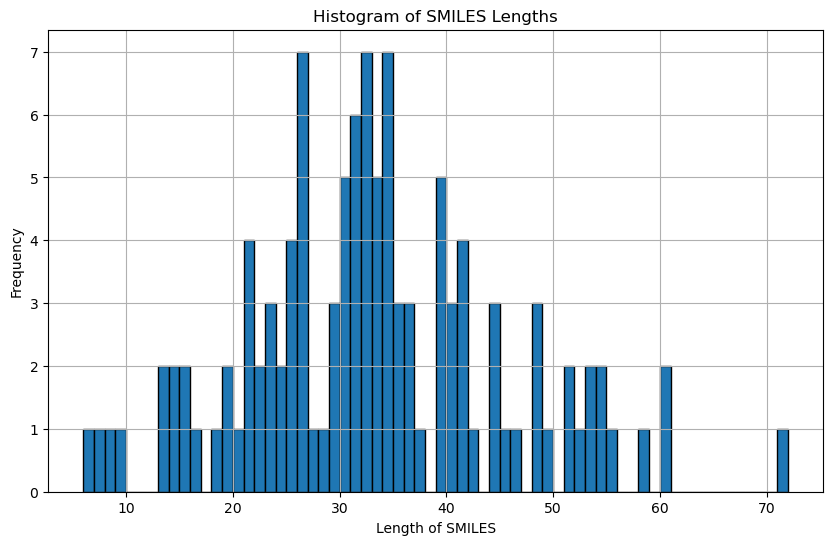

In [15]:
"""
print(len(task_SMILES))
print(task_SMILES[0])
smiles_lengths = [len(smiles) for smiles in task_SMILES]

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(smiles_lengths, bins=range(min(smiles_lengths), max(smiles_lengths) + 2), edgecolor='black')
plt.title('Histogram of SMILES Lengths')
plt.xlabel('Length of SMILES')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()
"""


### Get attention for SMILES from delaney dataset

In [15]:
smiles_to_att_dict = gather_attention_for_manySMILES(task_SMILES)

2025-01-22 10:13:26 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/smiles_atom_isomers_bart
2025-01-22 10:13:26 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:13:31 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:13:33 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:13:33 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:13:33 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:13:36 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:13:38 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:13:3

smiles:  c1cc2ccc3cccc4ccc(c1)c2c34
attention bart pretrained:  [(0.01732512377202511, 'c'), (0.054937172681093216, '1'), (0.04632049798965454, 'c'), (0.0780596062541008, 'c'), (0.11321026086807251, '2'), (0.05226176977157593, 'c'), (0.0405273474752903, 'c'), (0.04309419170022011, 'c'), (0.03298041224479675, '3'), (0.026332708075642586, 'c'), (0.0251452699303627, 'c'), (0.023848513141274452, 'c'), (0.02334529347717762, 'c'), (0.025911441072821617, '4'), (0.02311009354889393, 'c'), (0.0630725547671318, 'c'), (0.031490519642829895, 'c'), (0.038192104548215866, '('), (0.02230510301887989, 'c'), (0.049464356154203415, '1'), (0.02806857042014599, ')'), (0.021691681817173958, 'c'), (0.043774139136075974, '2'), (0.02073969505727291, 'c'), (0.02407986670732498, '3'), (0.030711716040968895, '4')]


2025-01-22 10:13:50 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:13:51 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:13:52 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:13:52 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:13:52 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:13:54 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:13:54 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:13:54 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:13:

smiles:  Cc1cc(=O)[nH]c(=S)[nH]1
attention bart pretrained:  [(0.06034648418426514, 'C'), (0.04564644396305084, 'c'), (0.1153559759259224, '1'), (0.05812828615307808, 'c'), (0.14591284096240997, 'c'), (0.06003831699490547, '('), (0.07186130434274673, '='), (0.09449896961450577, 'O'), (0.03636985272169113, ')'), (0.03365498036146164, '[nH]'), (0.024740194901823997, 'c'), (0.07627929747104645, '('), (0.028836989775300026, '='), (0.04184773564338684, 'S'), (0.029796674847602844, ')'), (0.027366027235984802, '[nH]'), (0.04931960999965668, '1')]


2025-01-22 10:13:59 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:14:00 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:14:01 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:14:01 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:14:01 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:14:02 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:14:03 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:14:03 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:14:

smiles:  O=C1OC(c2ccc(O)cc2)(c2ccc(O)cc2)c2ccccc21
attention bart pretrained:  [(0.018559684976935387, 'O'), (0.024366669356822968, '='), (0.05955210700631142, 'C'), (0.0771082416176796, '1'), (0.02617310918867588, 'O'), (0.15200884640216827, 'C'), (0.02446492202579975, '('), (0.035521894693374634, 'c'), (0.03487030789256096, '2'), (0.019726969301700592, 'c'), (0.016839196905493736, 'c'), (0.016442593187093735, 'c'), (0.022006159648299217, '('), (0.023914121091365814, 'O'), (0.013762102462351322, ')'), (0.029334230348467827, 'c'), (0.01635577529668808, 'c'), (0.03236379101872444, '2'), (0.012666705064475536, ')'), (0.01811879873275757, '('), (0.01103699579834938, 'c'), (0.022598261013627052, '2'), (0.01237382274121046, 'c'), (0.011143566109240055, 'c'), (0.01079558301717043, 'c'), (0.019674405455589294, '('), (0.021513797342777252, 'O'), (0.013539700768887997, ')'), (0.010212781839072704, 'c'), (0.011107360012829304, 'c'), (0.024863319471478462, '2'), (0.013818473555147648, ')'), (0.01

2025-01-22 10:14:07 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:14:09 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:14:09 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:14:09 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:14:10 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:14:11 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:14:11 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:14:11 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:14:

smiles:  c1ccc2c(c1)cc1ccc3cccc4ccc2c1c34
attention bart pretrained:  [(0.011829216033220291, 'c'), (0.04388013482093811, '1'), (0.032775815576314926, 'c'), (0.04205363616347313, 'c'), (0.03952357545495033, 'c'), (0.1251126229763031, '2'), (0.12319552898406982, 'c'), (0.030606212094426155, '('), (0.022185930982232094, 'c'), (0.04280683770775795, '1'), (0.023986810818314552, ')'), (0.02023438923060894, 'c'), (0.019075516611337662, 'c'), (0.03994226083159447, '1'), (0.0170725267380476, 'c'), (0.03630061447620392, 'c'), (0.024259956553578377, 'c'), (0.02513975463807583, '3'), (0.017381936311721802, 'c'), (0.015535072423517704, 'c'), (0.015011843293905258, 'c'), (0.015602790750563145, 'c'), (0.01922234706580639, '4'), (0.01604023203253746, 'c'), (0.01612747274339199, 'c'), (0.0166147630661726, 'c'), (0.0387505404651165, '2'), (0.016215695068240166, 'c'), (0.03376838192343712, '1'), (0.015266072936356068, 'c'), (0.021833449602127075, '3'), (0.022648053243756294, '4')]


2025-01-22 10:14:16 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:14:18 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:14:19 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:14:19 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:14:19 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:14:21 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:14:21 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:14:21 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:14:

smiles:  C1=Cc2cccc3cccc1c23
attention bart pretrained:  [(0.045777518302202225, 'C'), (0.08938423544168472, '1'), (0.05295529589056969, '='), (0.1572214663028717, 'C'), (0.03477858006954193, 'c'), (0.08816436678171158, '2'), (0.057113971561193466, 'c'), (0.026051117107272148, 'c'), (0.021569782868027687, 'c'), (0.02282155118882656, 'c'), (0.03987447917461395, '3'), (0.023206928744912148, 'c'), (0.023203542456030846, 'c'), (0.02348642237484455, 'c'), (0.02357703633606434, 'c'), (0.11899498850107193, '1'), (0.02463763952255249, 'c'), (0.0876387432217598, '2'), (0.039542339742183685, '3')]


2025-01-22 10:14:26 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:14:28 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:14:28 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:14:28 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:14:28 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:14:30 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:14:30 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:14:30 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:14:

smiles:  CC1CO1
attention bart pretrained:  [(0.10607094317674637, 'C'), (0.13691917061805725, 'C'), (0.11046541482210159, '1'), (0.13648809492588043, 'C'), (0.21280939877033234, 'O'), (0.2972469627857208, '1')]


2025-01-22 10:14:36 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:14:37 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:14:37 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:14:37 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:14:38 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:14:39 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:14:40 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:14:40 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:14:

smiles:  CCN1c2ccccc2N(C)C(=S)c2cccnc21
attention bart pretrained:  [(0.02519354037940502, 'C'), (0.05291200801730156, 'C'), (0.034917738288640976, 'N'), (0.10511464625597, '1'), (0.0473814457654953, 'c'), (0.0841505229473114, '2'), (0.060878098011016846, 'c'), (0.0446317195892334, 'c'), (0.022386491298675537, 'c'), (0.019222842529416084, 'c'), (0.017607109621167183, 'c'), (0.034962695091962814, '2'), (0.02488071285188198, 'N'), (0.02808387763798237, '('), (0.048387814313173294, 'C'), (0.022916622459888458, ')'), (0.05069412291049957, 'C'), (0.02815212309360504, '('), (0.01274582277983427, '='), (0.017915936186909676, 'S'), (0.01804330013692379, ')'), (0.012744691222906113, 'c'), (0.034444089978933334, '2'), (0.01315802801400423, 'c'), (0.014143568463623524, 'c'), (0.01581728644669056, 'c'), (0.021326130256056786, 'n'), (0.015903880819678307, 'c'), (0.036528900265693665, '2'), (0.0347541980445385, '1')]


2025-01-22 10:14:45 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:14:47 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:14:47 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:14:47 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:14:47 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:14:49 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:14:49 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:14:49 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:14:

smiles:  CC12CCC3c4ccc(O)cc4CCC3C1CCC2=O
attention bart pretrained:  [(0.021200165152549744, 'C'), (0.04370908811688423, 'C'), (0.05284152925014496, '1'), (0.04980882629752159, '2'), (0.056922316551208496, 'C'), (0.04757110774517059, 'C'), (0.0754614844918251, 'C'), (0.028594141826033592, '3'), (0.03381655737757683, 'c'), (0.022824205458164215, '4'), (0.02130795828998089, 'c'), (0.027102718129754066, 'c'), (0.02383858524262905, 'c'), (0.03073248267173767, '('), (0.03518817946314812, 'O'), (0.033249787986278534, ')'), (0.023539597168564796, 'c'), (0.024324772879481316, 'c'), (0.023426109924912453, '4'), (0.03180531784892082, 'C'), (0.026689736172556877, 'C'), (0.026062466204166412, 'C'), (0.02255651168525219, '3'), (0.028954101726412773, 'C'), (0.03401131555438042, '1'), (0.030324622988700867, 'C'), (0.027735689654946327, 'C'), (0.026612209156155586, 'C'), (0.02370590716600418, '2'), (0.01541320513933897, '='), (0.030669311061501503, 'O')]


2025-01-22 10:14:54 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:14:56 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:14:56 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:14:56 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:14:57 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:14:58 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:14:59 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:14:59 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:14:

smiles:  Cn1cc(-c2ccccc2)c(=O)c(-c2cccc(C(F)(F)F)c2)c1
attention bart pretrained:  [(0.021059105172753334, 'C'), (0.02333373762667179, 'n'), (0.1221967563033104, '1'), (0.07533136010169983, 'c'), (0.05434015020728111, 'c'), (0.03301544114947319, '('), (0.036739736795425415, '-'), (0.05845749378204346, 'c'), (0.037812963128089905, '2'), (0.01323721930384636, 'c'), (0.012330063618719578, 'c'), (0.010526205413043499, 'c'), (0.010565144009888172, 'c'), (0.009382580406963825, 'c'), (0.02525412105023861, '2'), (0.014028492383658886, ')'), (0.010862655937671661, 'c'), (0.02326350100338459, '('), (0.011513639241456985, '='), (0.015945792198181152, 'O'), (0.013430077582597733, ')'), (0.008201303891837597, 'c'), (0.017401421442627907, '('), (0.017054228112101555, '-'), (0.00815596617758274, 'c'), (0.023467550054192543, '2'), (0.007602375466376543, 'c'), (0.007239021826535463, 'c'), (0.007406726945191622, 'c'), (0.008615851402282715, 'c'), (0.01995628885924816, '('), (0.026828443631529808, 'C'), 

2025-01-22 10:15:03 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:15:04 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:15:05 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:15:05 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:15:05 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:15:07 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:15:07 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:15:07 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:15:

smiles:  O=CNC(N1C=CN(C(NC=O)C(Cl)(Cl)Cl)C=C1)C(Cl)(Cl)Cl
attention bart pretrained:  [(0.011736828833818436, 'O'), (0.012813453562557697, '='), (0.02129836194217205, 'C'), (0.014288127422332764, 'N'), (0.022954238578677177, 'C'), (0.010643339715898037, '('), (0.017461735755205154, 'N'), (0.02203907072544098, '1'), (0.05337223410606384, 'C'), (0.0136842867359519, '='), (0.02118051052093506, 'C'), (0.01629076898097992, 'N'), (0.014712120406329632, '('), (0.04053724557161331, 'C'), (0.020032793283462524, '('), (0.019863739609718323, 'N'), (0.16847747564315796, 'C'), (0.045844629406929016, '='), (0.02538110502064228, 'O'), (0.012590167112648487, ')'), (0.023085473105311394, 'C'), (0.013931904919445515, '('), (0.01964905671775341, 'Cl'), (0.0138941565528512, ')'), (0.015099689364433289, '('), (0.02146364003419876, 'Cl'), (0.017128361389040947, ')'), (0.022576047107577324, 'Cl'), (0.015175488777458668, ')'), (0.022036047652363777, 'C'), (0.009178882464766502, '='), (0.020634764805436134, 'C

2025-01-22 10:15:12 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:15:13 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:15:14 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:15:14 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:15:14 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:15:15 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:15:16 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:15:16 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:15:

smiles:  COc1c2occc2cc2ccc(=O)oc12
attention bart pretrained:  [(0.03155689686536789, 'C'), (0.04978448152542114, 'O'), (0.02452964149415493, 'c'), (0.08046887069940567, '1'), (0.06652432680130005, 'c'), (0.1728815883398056, '2'), (0.035787418484687805, 'o'), (0.04284244775772095, 'c'), (0.01950899139046669, 'c'), (0.01442825049161911, 'c'), (0.0435064435005188, '2'), (0.014334265142679214, 'c'), (0.015103976242244244, 'c'), (0.04461042582988739, '2'), (0.012823554687201977, 'c'), (0.04575994238257408, 'c'), (0.027676785364747047, 'c'), (0.057792603969573975, '('), (0.02249840833246708, '='), (0.03288647532463074, 'O'), (0.02136179804801941, ')'), (0.023302225396037102, 'o'), (0.01312930416315794, 'c'), (0.04228310286998749, '1'), (0.04461779072880745, '2')]


2025-01-22 10:15:20 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:15:21 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:15:22 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:15:22 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:15:22 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:15:23 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:15:24 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:15:24 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:15:

smiles:  CN1C(C(=O)Nc2ccccn2)=C(O)c2ccccc2S1(=O)=O
attention bart pretrained:  [(0.020206281915307045, 'C'), (0.02629443071782589, 'N'), (0.060508545488119125, '1'), (0.06794793158769608, 'C'), (0.030010534450411797, '('), (0.175672248005867, 'C'), (0.033380523324012756, '('), (0.023358134552836418, '='), (0.04437710717320442, 'O'), (0.015399008989334106, ')'), (0.015330281108617783, 'N'), (0.01248014997690916, 'c'), (0.024385564029216766, '2'), (0.008886943571269512, 'c'), (0.009817827492952347, 'c'), (0.023903071880340576, 'c'), (0.013336666859686375, 'c'), (0.018465295433998108, 'n'), (0.027502143755555153, '2'), (0.015080947428941727, ')'), (0.010808656923472881, '='), (0.02036486566066742, 'C'), (0.01732982136309147, '('), (0.021318940445780754, 'O'), (0.0149970268830657, ')'), (0.008326409384608269, 'c'), (0.022134514525532722, '2'), (0.0078056869097054005, 'c'), (0.00791365560144186, 'c'), (0.008657407015562057, 'c'), (0.00935471523553133, 'c'), (0.009275893680751324, 'c'), (0.0

2025-01-22 10:15:28 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:15:29 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:15:30 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:15:30 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:15:30 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:15:31 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:15:32 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:15:32 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:15:

smiles:  Cc1cc2nc3c(=O)[nH]c(=O)nc-3n(CC(O)C(O)C(O)CO)c2cc1C
attention bart pretrained:  [(0.020659731701016426, 'C'), (0.033281777054071426, 'c'), (0.04907022416591644, '1'), (0.05515964701771736, 'c'), (0.10648613423109055, 'c'), (0.09042591601610184, '2'), (0.026127086952328682, 'n'), (0.03697916492819786, 'c'), (0.025161830708384514, '3'), (0.01981620490550995, 'c'), (0.015510874800384045, '('), (0.014475096017122269, '='), (0.014362470246851444, 'O'), (0.012136715464293957, ')'), (0.010664831846952438, '[nH]'), (0.02059507928788662, 'c'), (0.015541045926511288, '('), (0.014608838595449924, '='), (0.014669365249574184, 'O'), (0.01292359922081232, ')'), (0.00932870339602232, 'n'), (0.010535124689340591, 'c'), (0.016113338991999626, '-'), (0.00936908833682537, '3'), (0.008766735903918743, 'n'), (0.011349470354616642, '('), (0.017990339547395706, 'C'), (0.018515989184379578, 'C'), (0.010327265597879887, '('), (0.014936511404812336, 'O'), (0.01206226646900177, ')'), (0.0164646264165639

2025-01-22 10:15:36 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:15:38 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:15:38 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:15:38 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:15:39 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:15:40 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:15:40 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:15:40 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:15:

smiles:  c1ccc(-c2ccc(-c3ccccc3)cc2)cc1
attention bart pretrained:  [(0.012979116290807724, 'c'), (0.05206674337387085, '1'), (0.043344587087631226, 'c'), (0.06802304089069366, 'c'), (0.11349963396787643, 'c'), (0.03631385788321495, '('), (0.03609313815832138, '-'), (0.060733895748853683, 'c'), (0.0780116394162178, '2'), (0.031115636229515076, 'c'), (0.029862055554986, 'c'), (0.023977359756827354, 'c'), (0.033682405948638916, '('), (0.03028392791748047, '-'), (0.015614081174135208, 'c'), (0.026519378647208214, '3'), (0.025465479120612144, 'c'), (0.021467000246047974, 'c'), (0.017037294805049896, 'c'), (0.016505030915141106, 'c'), (0.015881890431046486, 'c'), (0.022201212123036385, '3'), (0.02449638582766056, ')'), (0.01616044156253338, 'c'), (0.0164664164185524, 'c'), (0.03940406069159508, '2'), (0.024971595034003258, ')'), (0.014259799383580685, 'c'), (0.0144337834790349, 'c'), (0.0391291119158268, '1')]


2025-01-22 10:15:46 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:15:47 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:15:47 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:15:47 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:15:48 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:15:49 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:15:50 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:15:50 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:15:

smiles:  CC12CC(=O)C3C(CCC4=CC(=O)CCC43C)C1CCC2=O
attention bart pretrained:  [(0.014001798816025257, 'C'), (0.018169181421399117, 'C'), (0.0174091923981905, '1'), (0.01976512186229229, '2'), (0.026033515110611916, 'C'), (0.01645982451736927, 'C'), (0.020333873108029366, '('), (0.030936667695641518, '='), (0.05303341522812843, 'O'), (0.031238749623298645, ')'), (0.021049747243523598, 'C'), (0.014119093306362629, '3'), (0.026110151782631874, 'C'), (0.016136473044753075, '('), (0.019164204597473145, 'C'), (0.031898558139801025, 'C'), (0.02919044904410839, 'C'), (0.019284406676888466, '4'), (0.04646565020084381, '='), (0.143069788813591, 'C'), (0.015656476840376854, 'C'), (0.01870884746313095, '('), (0.012665039859712124, '='), (0.019336478784680367, 'O'), (0.019738543778657913, ')'), (0.016466734930872917, 'C'), (0.016609150916337967, 'C'), (0.01622076891362667, 'C'), (0.016145067289471626, '4'), (0.014989224262535572, '3'), (0.022941408678889275, 'C'), (0.023920411244034767, ')'), (0.02

2025-01-22 10:15:54 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:15:55 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:15:56 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:15:56 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:15:56 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:15:57 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:15:58 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:15:58 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:15:

smiles:  c1ccc2c(c1)sc1ccccc12
attention bart pretrained:  [(0.018462220206856728, 'c'), (0.10290346294641495, '1'), (0.038470085710287094, 'c'), (0.03993773087859154, 'c'), (0.039865996688604355, 'c'), (0.0726851150393486, '2'), (0.0458926223218441, 'c'), (0.05344420298933983, '('), (0.033508334308862686, 'c'), (0.10235755890607834, '1'), (0.039367225021123886, ')'), (0.047425005584955215, 's'), (0.030875572934746742, 'c'), (0.056855831295251846, '1'), (0.0253334641456604, 'c'), (0.05050790309906006, 'c'), (0.034667421132326126, 'c'), (0.027558891102671623, 'c'), (0.026326222345232964, 'c'), (0.05906727910041809, '1'), (0.054487865418195724, '2')]


2025-01-22 10:16:02 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:16:04 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:16:04 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:16:04 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:16:04 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:16:06 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:16:06 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:16:06 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:16:

smiles:  C#CC1(O)CCC2C3CCC4=Cc5oncc5CC4(C)C3CCC21C
attention bart pretrained:  [(0.014741512946784496, 'C'), (0.01159229502081871, '#'), (0.0120961619541049, 'C'), (0.011413472704589367, 'C'), (0.013656516559422016, '1'), (0.014347326010465622, '('), (0.022582123056054115, 'O'), (0.027617746964097023, ')'), (0.03494630753993988, 'C'), (0.01955549232661724, 'C'), (0.018825547769665718, 'C'), (0.025081945583224297, '2'), (0.03661554306745529, 'C'), (0.017548754811286926, '3'), (0.04185345768928528, 'C'), (0.04456568881869316, 'C'), (0.04596783593297005, 'C'), (0.019892383366823196, '4'), (0.044296395033597946, '='), (0.025402136147022247, 'C'), (0.021549584344029427, 'c'), (0.02337753027677536, '5'), (0.02310056798160076, 'o'), (0.01929587312042713, 'n'), (0.02411792427301407, 'c'), (0.022669104859232903, 'c'), (0.022898569703102112, '5'), (0.026569345965981483, 'C'), (0.019954627379775047, 'C'), (0.016651201993227005, '4'), (0.021499117836356163, '('), (0.02774776518344879, 'C'), (0.026

2025-01-22 10:16:11 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:16:12 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:16:13 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:16:13 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:16:13 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:16:14 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:16:15 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:16:15 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:16:

smiles:  O=C(c1ccccc1)C(O)c1ccccc1
attention bart pretrained:  [(0.03407348319888115, 'O'), (0.04812470078468323, '='), (0.07212982326745987, 'C'), (0.030027100816369057, '('), (0.034689366817474365, 'c'), (0.06913361698389053, '1'), (0.062177542597055435, 'c'), (0.04057600721716881, 'c'), (0.031673867255449295, 'c'), (0.03087027370929718, 'c'), (0.035798896104097366, 'c'), (0.08990152925252914, '1'), (0.031736716628074646, ')'), (0.06483500450849533, 'C'), (0.03670792654156685, '('), (0.04177497327327728, 'O'), (0.02294791489839554, ')'), (0.023044168949127197, 'c'), (0.04151589795947075, '1'), (0.016599027439951897, 'c'), (0.017140036448836327, 'c'), (0.02057446725666523, 'c'), (0.02715357206761837, 'c'), (0.019730757921934128, 'c'), (0.057063356041908264, '1')]


2025-01-22 10:16:19 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:16:21 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:16:21 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:16:21 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:16:21 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:16:23 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:16:23 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:16:23 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:16:

smiles:  OCc1ccccc1OC1OC(CO)C(O)C(O)C1O
attention bart pretrained:  [(0.01981326751410961, 'O'), (0.03643782064318657, 'C'), (0.03504250571131706, 'c'), (0.07038050144910812, '1'), (0.12816761434078217, 'c'), (0.05760157108306885, 'c'), (0.045415058732032776, 'c'), (0.038069769740104675, 'c'), (0.03713475540280342, 'c'), (0.04376210272312164, '1'), (0.03482070937752724, 'O'), (0.02810816653072834, 'C'), (0.023370137438178062, '1'), (0.023766277357935905, 'O'), (0.02047497220337391, 'C'), (0.021000079810619354, '('), (0.024842267856001854, 'C'), (0.023459283635020256, 'O'), (0.020944906398653984, ')'), (0.018805615603923798, 'C'), (0.022177748382091522, '('), (0.02876654453575611, 'O'), (0.023610634729266167, ')'), (0.01847437582910061, 'C'), (0.02117248624563217, '('), (0.029599696397781372, 'O'), (0.028058955445885658, ')'), (0.02545946277678013, 'C'), (0.019320128485560417, '1'), (0.03194260224699974, 'O')]


2025-01-22 10:16:27 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:16:29 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:16:29 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:16:29 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:16:30 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:16:31 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:16:31 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:16:31 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:16:

smiles:  CC1=C2C3OC(=O)C(C)C3CCC2(C)C=CC1=O
attention bart pretrained:  [(0.014997436664998531, 'C'), (0.028941437602043152, 'C'), (0.02998924069106579, '1'), (0.022391313686966896, '='), (0.1688040941953659, 'C'), (0.030317815020680428, '2'), (0.028992442414164543, 'C'), (0.02624691091477871, '3'), (0.032849013805389404, 'O'), (0.03606460615992546, 'C'), (0.0205108430236578, '('), (0.015474896878004074, '='), (0.036048635840415955, 'O'), (0.025630610063672066, ')'), (0.02299809455871582, 'C'), (0.02144678682088852, '('), (0.047990743070840836, 'C'), (0.0358872227370739, ')'), (0.03357936814427376, 'C'), (0.01496566366404295, '3'), (0.01684088073670864, 'C'), (0.01749311201274395, 'C'), (0.016653964295983315, 'C'), (0.020329123362898827, '2'), (0.02187463827431202, '('), (0.022654974833130836, 'C'), (0.027209244668483734, ')'), (0.022228935733437538, 'C'), (0.014363143593072891, '='), (0.02045825868844986, 'C'), (0.023264219984412193, 'C'), (0.02785850502550602, '1'), (0.02089027501642

2025-01-22 10:16:36 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:16:37 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:16:37 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:16:37 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:16:38 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:16:39 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:16:39 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:16:39 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:16:

smiles:  O=Cc1ccc2c(c1)OCO2
attention bart pretrained:  [(0.04056435450911522, 'O'), (0.04853936657309532, '='), (0.07731444388628006, 'C'), (0.025621844455599785, 'c'), (0.12898989021778107, '1'), (0.03594665974378586, 'c'), (0.04656040295958519, 'c'), (0.035249773412942886, 'c'), (0.05055685341358185, '2'), (0.026778986677527428, 'c'), (0.05354868248105049, '('), (0.025163523852825165, 'c'), (0.07340279221534729, '1'), (0.04169416055083275, ')'), (0.05658380687236786, 'O'), (0.13896287977695465, 'C'), (0.04709240794181824, 'O'), (0.047429174184799194, '2')]


2025-01-22 10:16:44 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:16:46 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:16:46 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:16:46 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:16:46 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:16:48 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:16:48 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:16:48 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:16:

smiles:  CC1CCCCC1NC(=O)Nc1ccccc1
attention bart pretrained:  [(0.028114741668105125, 'C'), (0.07932739704847336, 'C'), (0.05200575664639473, '1'), (0.02947167120873928, 'C'), (0.021378135308623314, 'C'), (0.0258013978600502, 'C'), (0.0323655866086483, 'C'), (0.06980470567941666, 'C'), (0.0561186708509922, '1'), (0.0492662638425827, 'N'), (0.14562253654003143, 'C'), (0.0832708403468132, '('), (0.029657280072569847, '='), (0.04647694155573845, 'O'), (0.030066289007663727, ')'), (0.02469445951282978, 'N'), (0.011307013221085072, 'c'), (0.032127950340509415, '1'), (0.012985840439796448, 'c'), (0.015423157252371311, 'c'), (0.016659332439303398, 'c'), (0.018141401931643486, 'c'), (0.026167547330260277, 'c'), (0.06374511122703552, '1')]


2025-01-22 10:16:53 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:16:54 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:16:54 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:16:54 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:16:55 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:16:56 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:16:57 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:16:57 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:16:

smiles:  CC(=O)N(c1onc(C)c1C)S(=O)c1ccc(N)cc1
attention bart pretrained:  [(0.019262954592704773, 'C'), (0.039495211094617844, 'C'), (0.038759876042604446, '('), (0.036878298968076706, '='), (0.026025431230664253, 'O'), (0.01670847088098526, ')'), (0.027507657185196877, 'N'), (0.029872186481952667, '('), (0.08448246866464615, 'c'), (0.17647846043109894, '1'), (0.01899920590221882, 'o'), (0.014437663368880749, 'n'), (0.008448968641459942, 'c'), (0.020765749737620354, '('), (0.02815759927034378, 'C'), (0.015670688822865486, ')'), (0.007484846282750368, 'c'), (0.041930798441171646, '1'), (0.029955200850963593, 'C'), (0.018008746206760406, ')'), (0.021776890382170677, 'S'), (0.027621276676654816, '('), (0.011754893697798252, '='), (0.01947164721786976, 'O'), (0.018441518768668175, ')'), (0.00803766492754221, 'c'), (0.028580104932188988, '1'), (0.008207198232412338, 'c'), (0.00838819332420826, 'c'), (0.011342807672917843, 'c'), (0.035124000161886215, '('), (0.026314912363886833, 'N'), (0.02

2025-01-22 10:17:01 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:17:03 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:17:03 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:17:03 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:17:03 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:17:05 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:17:05 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:17:05 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:17:

smiles:  CC(C)CNC(=O)N1CCNC1=O
attention bart pretrained:  [(0.01902344636619091, 'C'), (0.0400388203561306, 'C'), (0.03298215568065643, '('), (0.04814321920275688, 'C'), (0.03632253035902977, ')'), (0.03410010039806366, 'C'), (0.04378541186451912, 'N'), (0.24051539599895477, 'C'), (0.084004245698452, '('), (0.03599034622311592, '='), (0.05321001634001732, 'O'), (0.04277997836470604, ')'), (0.032229941338300705, 'N'), (0.028920277953147888, '1'), (0.03348282352089882, 'C'), (0.03146984055638313, 'C'), (0.030972084030508995, 'N'), (0.02647421695291996, 'C'), (0.030874548479914665, '1'), (0.024959729984402657, '='), (0.04972086474299431, 'O')]


2025-01-22 10:17:09 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:17:11 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:17:11 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:17:11 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:17:11 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:17:13 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:17:13 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:17:13 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:17:

smiles:  CNC(=O)Oc1ccccc1C1OCCO1
attention bart pretrained:  [(0.029166409745812416, 'C'), (0.05014998838305473, 'N'), (0.09948661923408508, 'C'), (0.044343650341033936, '('), (0.09063021093606949, '='), (0.03866337612271309, 'O'), (0.030978411436080933, ')'), (0.0511750765144825, 'O'), (0.07144930213689804, 'c'), (0.042068470269441605, '1'), (0.019633924588561058, 'c'), (0.01684683747589588, 'c'), (0.01934409886598587, 'c'), (0.019823579117655754, 'c'), (0.022951899096369743, 'c'), (0.07509543746709824, '1'), (0.04716836288571358, 'C'), (0.02878233976662159, '1'), (0.03439606353640556, 'O'), (0.05406944826245308, 'C'), (0.03529071807861328, 'C'), (0.036477237939834595, 'O'), (0.042008548974990845, '1')]


2025-01-22 10:17:17 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:17:19 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:17:19 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:17:19 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:17:19 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:17:21 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:17:21 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:17:21 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:17:

smiles:  CC1=C(C(=O)Nc2ccccc2)CCCO1
attention bart pretrained:  [(0.023637359961867332, 'C'), (0.04406058415770531, 'C'), (0.08517848700284958, '1'), (0.0322696715593338, '='), (0.06463545560836792, 'C'), (0.028656436130404472, '('), (0.14133132994174957, 'C'), (0.06372713297605515, '('), (0.05132053419947624, '='), (0.031439509242773056, 'O'), (0.021051770076155663, ')'), (0.02328353561460972, 'N'), (0.014856237918138504, 'c'), (0.03801536187529564, '2'), (0.012733031064271927, 'c'), (0.02265988104045391, 'c'), (0.01684628799557686, 'c'), (0.017942141741514206, 'c'), (0.017977895215153694, 'c'), (0.044106513261795044, '2'), (0.027508139610290527, ')'), (0.03387804701924324, 'C'), (0.030438637360930443, 'C'), (0.02887379378080368, 'C'), (0.033190179616212845, 'O'), (0.050382066518068314, '1')]


2025-01-22 10:17:25 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:17:27 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:17:27 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:17:27 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:17:27 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:17:29 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:17:29 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:17:29 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:17:

smiles:  Cn1c(=O)on(-c2ccc(Cl)c(Cl)c2)c1=O
attention bart pretrained:  [(0.02434300072491169, 'C'), (0.038623932749032974, 'n'), (0.13023565709590912, '1'), (0.06377042084932327, 'c'), (0.05073424056172371, '('), (0.058418381959199905, '='), (0.10170025378465652, 'O'), (0.024145901203155518, ')'), (0.03190268948674202, 'o'), (0.02640005201101303, 'n'), (0.024951329454779625, '('), (0.022262530401349068, '-'), (0.013202796690165997, 'c'), (0.029951849952340126, '2'), (0.011912995018064976, 'c'), (0.030102647840976715, 'c'), (0.022399289533495903, 'c'), (0.034246776252985, '('), (0.03237699344754219, 'Cl'), (0.01586698740720749, ')'), (0.012199931778013706, 'c'), (0.025503993034362793, '('), (0.02251506596803665, 'Cl'), (0.016208043321967125, ')'), (0.011297985911369324, 'c'), (0.0316886380314827, '2'), (0.01931736059486866, ')'), (0.011408146470785141, 'c'), (0.026699410751461983, '1'), (0.012280072085559368, '='), (0.02333260141313076, 'O')]


2025-01-22 10:17:33 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:17:35 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:17:35 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:17:35 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:17:36 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:17:37 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:17:37 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:17:37 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:17:

smiles:  c1cc2c3c(cccc3c1)CC2
attention bart pretrained:  [(0.02131187729537487, 'c'), (0.07627004384994507, '1'), (0.04155085235834122, 'c'), (0.04802754893898964, 'c'), (0.10202945023775101, '2'), (0.09595987945795059, 'c'), (0.07742854207754135, '3'), (0.05604565143585205, 'c'), (0.042964059859514236, '('), (0.028996510431170464, 'c'), (0.027562623843550682, 'c'), (0.027284378185868263, 'c'), (0.027473947033286095, 'c'), (0.03878084942698479, '3'), (0.026078591123223305, 'c'), (0.07925257831811905, '1'), (0.03616897389292717, ')'), (0.06547854095697403, 'C'), (0.04160935804247856, 'C'), (0.03972573205828667, '2')]


2025-01-22 10:17:42 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:17:43 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:17:43 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:17:43 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:17:44 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:17:45 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:17:46 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:17:46 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:17:

smiles:  c1ccc2cc3c(cc2c1)-c1cccc2cccc-3c12
attention bart pretrained:  [(0.009711450897157192, 'c'), (0.036646388471126556, '1'), (0.021104924380779266, 'c'), (0.01962515152990818, 'c'), (0.03909184783697128, 'c'), (0.1012885645031929, '2'), (0.11853107810020447, 'c'), (0.03670017048716545, 'c'), (0.021595127880573273, '3'), (0.01590724103152752, 'c'), (0.030009856447577477, '('), (0.015246768482029438, 'c'), (0.014247397892177105, 'c'), (0.03066139854490757, '2'), (0.012518218718469143, 'c'), (0.10840656608343124, '1'), (0.023470329120755196, ')'), (0.02723519690334797, '-'), (0.014636619947850704, 'c'), (0.034293282777071, '1'), (0.012525401078164577, 'c'), (0.013314283452928066, 'c'), (0.013696773909032345, 'c'), (0.014051050879061222, 'c'), (0.030111053958535194, '2'), (0.012805450707674026, 'c'), (0.01262677926570177, 'c'), (0.013474956154823303, 'c'), (0.013972711749374866, 'c'), (0.03361037001013756, '-'), (0.020924260839819908, '3'), (0.0151471346616745, 'c'), (0.0308353230357

2025-01-22 10:17:50 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:17:52 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:17:52 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:17:52 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:17:52 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:17:54 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:17:54 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:17:54 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:17:

smiles:  Nc1cc(N2CCCCC2)nc(N)[n+]1[O-]
attention bart pretrained:  [(0.02146001160144806, 'N'), (0.04110940173268318, 'c'), (0.04652666673064232, '1'), (0.07224922627210617, 'c'), (0.17667190730571747, 'c'), (0.07015581429004669, '('), (0.07332426309585571, 'N'), (0.06146744266152382, '2'), (0.034886594861745834, 'C'), (0.029529497027397156, 'C'), (0.02776305377483368, 'C'), (0.023963913321495056, 'C'), (0.025349391624331474, 'C'), (0.03584578260779381, '2'), (0.027662241831421852, ')'), (0.021481992676854134, 'n'), (0.03000417910516262, 'c'), (0.034937139600515366, '('), (0.03589150309562683, 'N'), (0.03187057375907898, ')'), (0.026331769302487373, '[n+]'), (0.032427314668893814, '1'), (0.019090309739112854, '[O-]')]


2025-01-22 10:17:59 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:18:00 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:18:01 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:18:01 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:18:01 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:18:02 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:18:03 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:18:03 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:18:

smiles:  O=c1oc2ccccc2c(O)c1C1CCCc2ccccc21
attention bart pretrained:  [(0.02237718552350998, 'O'), (0.02760235033929348, '='), (0.025882022455334663, 'c'), (0.10411631315946579, '1'), (0.028685396537184715, 'o'), (0.02902842126786709, 'c'), (0.06430815905332565, '2'), (0.03748142719268799, 'c'), (0.02794315107166767, 'c'), (0.018651660531759262, 'c'), (0.016845203936100006, 'c'), (0.017242277041077614, 'c'), (0.034592460840940475, '2'), (0.01522120926529169, 'c'), (0.026520704850554466, '('), (0.033808283507823944, 'O'), (0.018144162371754646, ')'), (0.02978898584842682, 'c'), (0.05126677080988884, '1'), (0.036784544587135315, 'C'), (0.03389083966612816, '1'), (0.03523023799061775, 'C'), (0.039099324494600296, 'C'), (0.028719760477542877, 'C'), (0.01409036386758089, 'c'), (0.03478924557566643, '2'), (0.013293281197547913, 'c'), (0.012172899208962917, 'c'), (0.012712307274341583, 'c'), (0.014688695780932903, 'c'), (0.015791434794664383, 'c'), (0.04373524710536003, '2'), (0.035495687276

2025-01-22 10:18:07 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:18:09 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:18:09 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:18:09 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:18:09 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:18:11 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:18:11 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:18:11 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:18:

smiles:  CC(C)C(Nc1ccc(C(F)(F)F)cc1Cl)C(=O)OC(C#N)c1cccc(Oc2ccccc2)c1
attention bart pretrained:  [(0.012027728371322155, 'C'), (0.033009957522153854, 'C'), (0.03155099228024483, '('), (0.1871739625930786, 'C'), (0.025046473369002342, ')'), (0.050747886300086975, 'C'), (0.013123561628162861, '('), (0.007901347242295742, 'N'), (0.009138427674770355, 'c'), (0.016553262248635292, '1'), (0.005828985944390297, 'c'), (0.010385082103312016, 'c'), (0.02182386815547943, 'c'), (0.020905012264847755, '('), (0.04705066606402397, 'C'), (0.03107692301273346, '('), (0.015494011342525482, 'F'), (0.008075417019426823, ')'), (0.009300573728978634, '('), (0.007987975142896175, 'F'), (0.009083494544029236, ')'), (0.008752943016588688, 'F'), (0.008452851325273514, ')'), (0.003985782619565725, 'c'), (0.005359321366995573, 'c'), (0.018352104350924492, '1'), (0.014330609701573849, 'Cl'), (0.011004806496202946, ')'), (0.015514195896685123, 'C'), (0.011390523053705692, '('), (0.007693479303270578, '='), (0.0163

2025-01-22 10:18:15 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:18:17 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:18:17 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:18:17 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:18:17 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:18:19 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:18:19 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:18:19 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:18:

smiles:  Cc1c(F)c(F)c(COC(=O)C2C(C=C(Cl)C(F)(F)F)C2(C)C)c(F)c1F
attention bart pretrained:  [(0.017469920217990875, 'C'), (0.01582993008196354, 'c'), (0.024284275248646736, '1'), (0.022569483146071434, 'c'), (0.020021066069602966, '('), (0.015522129833698273, 'F'), (0.011014296673238277, ')'), (0.024966126307845116, 'c'), (0.02563856728374958, '('), (0.020822590216994286, 'F'), (0.011165785603225231, ')'), (0.016128428280353546, 'c'), (0.02478308416903019, '('), (0.11432137340307236, 'C'), (0.02093052864074707, 'O'), (0.03943941742181778, 'C'), (0.020301515236496925, '('), (0.03129721060395241, '='), (0.04277564212679863, 'O'), (0.009979133494198322, ')'), (0.01758907549083233, 'C'), (0.01362049300223589, '2'), (0.01927676610648632, 'C'), (0.011840279214084148, '('), (0.025454720482230186, 'C'), (0.010225904174149036, '='), (0.01972932368516922, 'C'), (0.013873928226530552, '('), (0.01551183219999075, 'Cl'), (0.010519311763346195, ')'), (0.016405323520302773, 'C'), (0.01299662422388792

2025-01-22 10:18:23 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:18:25 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:18:25 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:18:25 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:18:25 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:18:27 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:18:27 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:18:27 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:18:

smiles:  c1ccc2[nH]nnc2c1
attention bart pretrained:  [(0.02264195866882801, 'c'), (0.09115064889192581, '1'), (0.04693099483847618, 'c'), (0.08490217477083206, 'c'), (0.1377621740102768, 'c'), (0.24107013642787933, '2'), (0.06389886885881424, '[nH]'), (0.04829125478863716, 'n'), (0.04400375485420227, 'n'), (0.030462751165032387, 'c'), (0.07120921462774277, '2'), (0.03193212300539017, 'c'), (0.08574392646551132, '1')]


2025-01-22 10:18:32 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:18:33 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:18:34 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:18:34 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:18:34 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:18:36 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:18:36 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:18:36 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:18:

smiles:  c1ccc2ocnc2c1
attention bart pretrained:  [(0.027397146448493004, 'c'), (0.09129732847213745, '1'), (0.05382760241627693, 'c'), (0.09992287307977676, 'c'), (0.14691968262195587, 'c'), (0.18881140649318695, '2'), (0.056593988090753555, 'o'), (0.04693201184272766, 'c'), (0.04964295029640198, 'n'), (0.03671609237790108, 'c'), (0.07937487214803696, '2'), (0.035554833710193634, 'c'), (0.08700919896364212, '1')]


2025-01-22 10:18:40 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:18:42 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:18:42 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:18:42 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:18:43 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:18:44 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:18:45 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:18:45 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:18:

smiles:  CCOC(=O)c1cncn1C(C)c1ccccc1
attention bart pretrained:  [(0.025519849732518196, 'C'), (0.0527566559612751, 'C'), (0.06925980001688004, 'O'), (0.19189070165157318, 'C'), (0.032245587557554245, '('), (0.020085113123059273, '='), (0.02736836113035679, 'O'), (0.02532423846423626, ')'), (0.02230372093617916, 'c'), (0.03761821240186691, '1'), (0.014868971891701221, 'c'), (0.027019599452614784, 'n'), (0.022600403055548668, 'c'), (0.037470024079084396, 'n'), (0.05908824875950813, '1'), (0.0806913748383522, 'C'), (0.029631823301315308, '('), (0.02883211337029934, 'C'), (0.021003812551498413, ')'), (0.012371577322483063, 'c'), (0.035523269325494766, '1'), (0.013375281356275082, 'c'), (0.013967934064567089, 'c'), (0.013979628682136536, 'c'), (0.016355689615011215, 'c'), (0.017213238403201103, 'c'), (0.0516347773373127, '1')]


2025-01-22 10:18:49 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:18:51 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:18:51 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:18:51 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:18:51 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:18:53 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:18:53 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:18:53 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:18:

smiles:  CCN1c2ccccc2C(=O)N(C)c2ccccc21
attention bart pretrained:  [(0.026411138474941254, 'C'), (0.05289103090763092, 'C'), (0.03402029350399971, 'N'), (0.06940879672765732, '1'), (0.06563941389322281, 'c'), (0.07470784336328506, '2'), (0.09530379623174667, 'c'), (0.030722567811608315, 'c'), (0.017300913110375404, 'c'), (0.018672490492463112, 'c'), (0.018920576199889183, 'c'), (0.04194061458110809, '2'), (0.053378090262413025, 'C'), (0.03296424075961113, '('), (0.016550112515687943, '='), (0.03395414724946022, 'O'), (0.018776817247271538, ')'), (0.023256244137883186, 'N'), (0.022336279973387718, '('), (0.03279227018356323, 'C'), (0.01836501620709896, ')'), (0.01227238867431879, 'c'), (0.03760873153805733, '2'), (0.012751930393278599, 'c'), (0.013577178120613098, 'c'), (0.01407944317907095, 'c'), (0.014418103732168674, 'c'), (0.014813336543738842, 'c'), (0.04111037775874138, '2'), (0.041055828332901, '1')]


2025-01-22 10:18:58 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:18:59 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:18:59 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:18:59 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:19:00 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:19:01 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:19:01 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:19:01 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:19:

smiles:  O=C(OCC(O)CO)c1ccccc1Nc1ccnc2cc(Cl)ccc12
attention bart pretrained:  [(0.018327511847019196, 'O'), (0.024524806067347527, '='), (0.03519502654671669, 'C'), (0.01823827438056469, '('), (0.040721263736486435, 'O'), (0.09478556364774704, 'C'), (0.11397675424814224, 'C'), (0.024394067004323006, '('), (0.036462005227804184, 'O'), (0.016602953895926476, ')'), (0.04853644594550133, 'C'), (0.0262200478464365, 'O'), (0.01618495024740696, ')'), (0.012484777718782425, 'c'), (0.029726454988121986, '1'), (0.03170501068234444, 'c'), (0.017863543704152107, 'c'), (0.01925007440149784, 'c'), (0.01181676983833313, 'c'), (0.01097459439188242, 'c'), (0.025443924590945244, '1'), (0.019086170941591263, 'N'), (0.012632406316697598, 'c'), (0.02323961816728115, '1'), (0.009380017407238483, 'c'), (0.009278212673962116, 'c'), (0.01845509000122547, 'n'), (0.010561060160398483, 'c'), (0.02702423371374607, '2'), (0.009505487978458405, 'c'), (0.011873357929289341, 'c'), (0.031852975487709045, '('), (0.02527

2025-01-22 10:19:06 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:19:08 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:19:08 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:19:08 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:19:08 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:19:10 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:19:10 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:19:10 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:19:

smiles:  OCC1OC(OC2C(CO)OC(O)C(O)C2O)C(O)C(O)C1O
attention bart pretrained:  [(0.014736536890268326, 'O'), (0.019518868997693062, 'C'), (0.01788337342441082, 'C'), (0.014642350375652313, '1'), (0.020733173936605453, 'O'), (0.015114818699657917, 'C'), (0.012276303954422474, '('), (0.025173842906951904, 'O'), (0.017301786690950394, 'C'), (0.01913490518927574, '2'), (0.015551759861409664, 'C'), (0.013059839606285095, '('), (0.03485659137368202, 'C'), (0.022588372230529785, 'O'), (0.03331470489501953, ')'), (0.050436899065971375, 'O'), (0.07602328062057495, 'C'), (0.01802767626941204, '('), (0.04392318055033684, 'O'), (0.02013569511473179, ')'), (0.06338782608509064, 'C'), (0.018179673701524734, '('), (0.033668313175439835, 'O'), (0.02257218025624752, ')'), (0.0406154990196228, 'C'), (0.023015929386019707, '2'), (0.02268480695784092, 'O'), (0.019078955054283142, ')'), (0.02108871005475521, 'C'), (0.017909690737724304, '('), (0.026838958263397217, 'O'), (0.020251525565981865, ')'), (0.02634

2025-01-22 10:19:15 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:19:16 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:19:17 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:19:17 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:19:17 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:19:19 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:19:19 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:19:19 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:19:

smiles:  CC12CCc3c(ccc4cc(O)ccc34)C1CCC2=O
attention bart pretrained:  [(0.02382642589509487, 'C'), (0.04191083833575249, 'C'), (0.04436216875910759, '1'), (0.039405155926942825, '2'), (0.10374642163515091, 'C'), (0.07495401054620743, 'C'), (0.07495561987161636, 'c'), (0.030830398201942444, '3'), (0.05589719116687775, 'c'), (0.027002587914466858, '('), (0.017589837312698364, 'c'), (0.016303369775414467, 'c'), (0.015246245078742504, 'c'), (0.019091425463557243, '4'), (0.012155718170106411, 'c'), (0.029124483466148376, 'c'), (0.02557145245373249, '('), (0.03357871249318123, 'O'), (0.019288143143057823, ')'), (0.012210610322654247, 'c'), (0.011206491850316525, 'c'), (0.012376516126096249, 'c'), (0.0194159634411335, '3'), (0.021109819412231445, '4'), (0.023867784067988396, ')'), (0.02777942270040512, 'C'), (0.02687113918364048, '1'), (0.02443842776119709, 'C'), (0.02143852971494198, 'C'), (0.023260721936821938, 'C'), (0.025496507063508034, '2'), (0.01519473921507597, '='), (0.0304931309074

2025-01-22 10:19:24 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:19:26 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:19:26 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:19:26 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:19:26 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:19:28 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:19:28 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:19:28 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:19:

smiles:  ClC1=C(Cl)C(Cl)(C2(Cl)C(Cl)=C(Cl)C(Cl)=C2Cl)C(Cl)=C1Cl
attention bart pretrained:  [(0.013215962797403336, 'Cl'), (0.016177088022232056, 'C'), (0.012393840588629246, '1'), (0.012470405548810959, '='), (0.013910769484937191, 'C'), (0.009597173891961575, '('), (0.014976934529840946, 'Cl'), (0.011947646737098694, ')'), (0.012903652153909206, 'C'), (0.015623756684362888, '('), (0.023317905142903328, 'Cl'), (0.01933768205344677, ')'), (0.012813598848879337, '('), (0.031339626759290695, 'C'), (0.026460813358426094, '2'), (0.012579367496073246, '('), (0.028688564896583557, 'Cl'), (0.020345032215118408, ')'), (0.03726722672581673, 'C'), (0.015641596168279648, '('), (0.0769374743103981, 'Cl'), (0.03486219793558121, ')'), (0.046769022941589355, '='), (0.02940867282450199, 'C'), (0.01920989342033863, '('), (0.026701083406805992, 'Cl'), (0.01995565928518772, ')'), (0.027148960158228874, 'C'), (0.018105680122971535, '('), (0.030610695481300354, 'Cl'), (0.020154321566224098, ')'), (0.015931

2025-01-22 10:19:33 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:19:34 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:19:34 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:19:34 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:19:35 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:19:36 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:19:36 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:19:36 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:19:

smiles:  O=C1C2(Cl)C3(Cl)C4(Cl)C(Cl)(Cl)C5(Cl)C3(Cl)C1(Cl)C5(Cl)C24Cl
attention bart pretrained:  [(0.008844426833093166, 'O'), (0.013691172935068607, '='), (0.012119677849113941, 'C'), (0.009281480684876442, '1'), (0.008335063233971596, 'C'), (0.009137707762420177, '2'), (0.009260227903723717, '('), (0.013172793202102184, 'Cl'), (0.00923269335180521, ')'), (0.008039229549467564, 'C'), (0.006457297131419182, '3'), (0.01069601345807314, '('), (0.01706000789999962, 'Cl'), (0.009354217909276485, ')'), (0.013198927976191044, 'C'), (0.007578984368592501, '4'), (0.0100436732172966, '('), (0.014281363226473331, 'Cl'), (0.009608889929950237, ')'), (0.011850446462631226, 'C'), (0.011851117014884949, '('), (0.04045878350734711, 'Cl'), (0.02849768102169037, ')'), (0.01941514015197754, '('), (0.043068185448646545, 'Cl'), (0.01514429971575737, ')'), (0.025561543181538582, 'C'), (0.015543043613433838, '5'), (0.01784571073949337, '('), (0.04319686070084572, 'Cl'), (0.021796956658363342, ')'), (0.0295

2025-01-22 10:19:41 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:19:42 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:19:43 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:19:43 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:19:43 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:19:45 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:19:45 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:19:45 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:19:

smiles:  O=c1c(O)c(-c2ccc(O)cc2O)oc2cc(O)cc(O)c12
attention bart pretrained:  [(0.01825757883489132, 'O'), (0.031986407935619354, '='), (0.027555346488952637, 'c'), (0.09646173566579819, '1'), (0.175481379032135, 'c'), (0.031240327283740044, '('), (0.03874479606747627, 'O'), (0.014753255061805248, ')'), (0.04349470138549805, 'c'), (0.024146059527993202, '('), (0.02029694803059101, '-'), (0.013701197691261768, 'c'), (0.024339230731129646, '2'), (0.010199216194450855, 'c'), (0.009996294043958187, 'c'), (0.023759881034493446, 'c'), (0.02138584293425083, '('), (0.02508392371237278, 'O'), (0.011884462088346481, ')'), (0.009025854989886284, 'c'), (0.009714256972074509, 'c'), (0.021308166906237602, '2'), (0.02205551601946354, 'O'), (0.012886487878859043, ')'), (0.01616164855659008, 'o'), (0.01054008025676012, 'c'), (0.023615645244717598, '2'), (0.009542097337543964, 'c'), (0.008534939028322697, 'c'), (0.019145002588629723, '('), (0.022256603464484215, 'O'), (0.01317473966628313, ')'), (0.0102

2025-01-22 10:19:49 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:19:51 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:19:51 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:19:51 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:19:52 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:19:53 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:19:53 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:19:53 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:19:

smiles:  O=C1CSC(=S)N1
attention bart pretrained:  [(0.04426668584346771, 'O'), (0.07089681178331375, '='), (0.06720931082963943, 'C'), (0.05779891088604927, '1'), (0.10952934622764587, 'C'), (0.06716889142990112, 'S'), (0.236029252409935, 'C'), (0.08611450344324112, '('), (0.04577769339084625, '='), (0.05087149143218994, 'S'), (0.06288744509220123, ')'), (0.05310091748833656, 'N'), (0.04834873974323273, '1')]


2025-01-22 10:19:58 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:19:59 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:20:00 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:20:00 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:20:00 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:20:01 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:20:02 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:20:02 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:20:

smiles:  O=C1C2CC=CCC2C(=O)N1SC(Cl)(Cl)C(Cl)Cl
attention bart pretrained:  [(0.017574766650795937, 'O'), (0.019143855199217796, '='), (0.0251080971211195, 'C'), (0.023053616285324097, '1'), (0.043351706117391586, 'C'), (0.02555806376039982, '2'), (0.033347394317388535, 'C'), (0.07784119248390198, 'C'), (0.05712530016899109, '='), (0.04471541941165924, 'C'), (0.022647207602858543, 'C'), (0.022648649290204048, 'C'), (0.02152269147336483, '2'), (0.026511168107390404, 'C'), (0.018839234486222267, '('), (0.025704776868224144, '='), (0.07234624773263931, 'O'), (0.02133045345544815, ')'), (0.024796217679977417, 'N'), (0.04855762794613838, '1'), (0.03273331746459007, 'S'), (0.027794772759079933, 'C'), (0.018516018986701965, '('), (0.02371194399893284, 'Cl'), (0.019253714010119438, ')'), (0.0196602214127779, '('), (0.026004670187830925, 'Cl'), (0.019746415317058563, ')'), (0.024023694917559624, 'C'), (0.021428465843200684, '('), (0.03039001114666462, 'Cl'), (0.03127773478627205, ')'), (0.033735

2025-01-22 10:20:06 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:20:08 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:20:08 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:20:08 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:20:08 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:20:10 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:20:10 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:20:10 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:20:

smiles:  ClC1=C(Cl)C2(Cl)C3C4C=CC(C4)C3C1(Cl)C2(Cl)Cl
attention bart pretrained:  [(0.02172914706170559, 'Cl'), (0.03118603676557541, 'C'), (0.019098665565252304, '1'), (0.007015689741820097, '='), (0.015320069156587124, 'C'), (0.009642384015023708, '('), (0.019196493551135063, 'Cl'), (0.010831833817064762, ')'), (0.016006777063012123, 'C'), (0.01964736171066761, '2'), (0.013145877979695797, '('), (0.028772586956620216, 'Cl'), (0.016659123823046684, ')'), (0.09901777654886246, 'C'), (0.019823787733912468, '3'), (0.0627942904829979, 'C'), (0.03075186349451542, '4'), (0.0955057367682457, 'C'), (0.01946725696325302, '='), (0.024130359292030334, 'C'), (0.02637525461614132, 'C'), (0.014054444618523121, '('), (0.02704155258834362, 'C'), (0.01665971241891384, '4'), (0.017555708065629005, ')'), (0.02791113406419754, 'C'), (0.014615860767662525, '3'), (0.02542220801115036, 'C'), (0.02470209449529648, '1'), (0.0213862806558609, '('), (0.026781074702739716, 'Cl'), (0.019275235012173653, ')'), (0.

2025-01-22 10:20:15 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:20:17 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:20:17 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:20:17 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:20:17 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:20:19 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:20:19 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:20:19 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:20:

smiles:  CC(=O)Nc1nnc(S(N)(=O)=O)s1
attention bart pretrained:  [(0.033906154334545135, 'C'), (0.10489431023597717, 'C'), (0.03816613554954529, '('), (0.02240220457315445, '='), (0.046581562608480453, 'O'), (0.04962930455803871, ')'), (0.08636611700057983, 'N'), (0.12965472042560577, 'c'), (0.10409784317016602, '1'), (0.025492774322628975, 'n'), (0.022005967795848846, 'n'), (0.016862718388438225, 'c'), (0.025525519624352455, '('), (0.022718211635947227, 'S'), (0.021302813664078712, '('), (0.01883762888610363, 'N'), (0.02494054101407528, ')'), (0.022464213892817497, '('), (0.015643659979104996, '='), (0.02761680819094181, 'O'), (0.029613299295306206, ')'), (0.014652424491941929, '='), (0.02986018918454647, 'O'), (0.02696332149207592, ')'), (0.012489239685237408, 's'), (0.02731231600046158, '1')]


2025-01-22 10:20:23 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:20:25 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:20:25 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:20:25 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:20:26 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:20:27 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:20:27 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:20:27 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:20:

smiles:  CC1=C(C(=O)Nc2ccccc2)SCCO1
attention bart pretrained:  [(0.023490222170948982, 'C'), (0.04501614347100258, 'C'), (0.08029742538928986, '1'), (0.028891272842884064, '='), (0.06883317977190018, 'C'), (0.029085354879498482, '('), (0.16032415628433228, 'C'), (0.05608498677611351, '('), (0.04447187855839729, '='), (0.04254143312573433, 'O'), (0.02300155721604824, ')'), (0.022826971486210823, 'N'), (0.012364176101982594, 'c'), (0.037485312670469284, '2'), (0.011517624370753765, 'c'), (0.02122414857149124, 'c'), (0.0161584485322237, 'c'), (0.017167700454592705, 'c'), (0.016825584694743156, 'c'), (0.042347025126218796, '2'), (0.027750976383686066, ')'), (0.02400924079120159, 'S'), (0.034835610538721085, 'C'), (0.02986878901720047, 'C'), (0.033077772706747055, 'O'), (0.05050298944115639, '1')]


2025-01-22 10:20:32 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:20:34 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:20:34 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:20:34 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:20:34 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:20:36 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:20:36 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:20:36 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:20:

smiles:  CN(C(=O)COc1nc2ccccc2s1)c1ccccc1
attention bart pretrained:  [(0.04073799028992653, 'C'), (0.031151453033089638, 'N'), (0.027188843116164207, '('), (0.05850604549050331, 'C'), (0.03034958429634571, '('), (0.036116983741521835, '='), (0.08540108054876328, 'O'), (0.027147525921463966, ')'), (0.16488270461559296, 'C'), (0.032285984605550766, 'O'), (0.015043302439153194, 'c'), (0.05895502492785454, '1'), (0.019995734095573425, 'n'), (0.010652386583387852, 'c'), (0.03598727285861969, '2'), (0.013152179308235645, 'c'), (0.012962478213012218, 'c'), (0.014517702162265778, 'c'), (0.014362056739628315, 'c'), (0.014737042598426342, 'c'), (0.037415776401758194, '2'), (0.015011225827038288, 's'), (0.03426187112927437, '1'), (0.020860591903328896, ')'), (0.009607365354895592, 'c'), (0.038601864129304886, '1'), (0.010116084478795528, 'c'), (0.008879454806447029, 'c'), (0.009779862128198147, 'c'), (0.012667031027376652, 'c'), (0.013283617794513702, 'c'), (0.04538188874721527, '1')]


2025-01-22 10:20:41 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:20:42 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:20:42 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:20:42 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:20:43 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:20:44 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:20:44 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:20:44 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:20:

smiles:  CN(C(=O)NC(C)(C)c1ccccc1)c1ccccc1
attention bart pretrained:  [(0.0302589014172554, 'C'), (0.034257445484399796, 'N'), (0.02320360392332077, '('), (0.07394779473543167, 'C'), (0.021401889622211456, '('), (0.02157449908554554, '='), (0.03311008960008621, 'O'), (0.0243054311722517, ')'), (0.04573260620236397, 'N'), (0.11041530221700668, 'C'), (0.030359191820025444, '('), (0.10422611236572266, 'C'), (0.021514544263482094, ')'), (0.024714620783925056, '('), (0.03490777686238289, 'C'), (0.018333135172724724, ')'), (0.011357739567756653, 'c'), (0.033413488417863846, '1'), (0.014200498349964619, 'c'), (0.01850493811070919, 'c'), (0.016428031027317047, 'c'), (0.015344531275331974, 'c'), (0.020588718354701996, 'c'), (0.037290334701538086, '1'), (0.023814164102077484, ')'), (0.012231691740453243, 'c'), (0.03534353896975517, '1'), (0.011634801514446735, 'c'), (0.011031077243387699, 'c'), (0.013742097653448582, 'c'), (0.01595328003168106, 'c'), (0.015297099016606808, 'c'), (0.041561026126

2025-01-22 10:20:49 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:20:50 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:20:51 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:20:51 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:20:51 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:20:53 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:20:53 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:20:53 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:20:

smiles:  Nc1nccs1
attention bart pretrained:  [(0.07141033560037613, 'N'), (0.07995892316102982, 'c'), (0.1762722283601761, '1'), (0.10014504939317703, 'n'), (0.05583089962601662, 'c'), (0.07329461723566055, 'c'), (0.19362597167491913, 's'), (0.24946199357509613, '1')]


2025-01-22 10:20:57 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:20:59 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:20:59 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:20:59 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:21:00 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:21:01 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:21:01 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:21:01 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:21:

smiles:  Cc1ccc(N=CN(C)C=Nc2ccc(C)cc2C)c(C)c1
attention bart pretrained:  [(0.024037720635533333, 'C'), (0.01738172024488449, 'c'), (0.05435711517930031, '1'), (0.027071276679635048, 'c'), (0.05033029243350029, 'c'), (0.07587531954050064, 'c'), (0.05553106963634491, '('), (0.030170395970344543, 'N'), (0.06879930198192596, '='), (0.07012247294187546, 'C'), (0.020514266565442085, 'N'), (0.01913502998650074, '('), (0.030459018424153328, 'C'), (0.014834091998636723, ')'), (0.026467325165867805, 'C'), (0.017501862719655037, '='), (0.0161051657050848, 'N'), (0.011616305448114872, 'c'), (0.029839878901839256, '2'), (0.007729061413556337, 'c'), (0.009073883295059204, 'c'), (0.009978591464459896, 'c'), (0.021846016868948936, '('), (0.02978854812681675, 'C'), (0.017271583899855614, ')'), (0.009566389955580235, 'c'), (0.010342713445425034, 'c'), (0.032682280987501144, '2'), (0.027250096201896667, 'C'), (0.01804548315703869, ')'), (0.009685422293841839, 'c'), (0.026077143847942352, '('), (0.035175

2025-01-22 10:21:06 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:21:07 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:21:07 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:21:07 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:21:08 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:21:09 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:21:09 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:21:09 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:21:

smiles:  OCC(O)C1OC2OC(C(Cl)(Cl)Cl)OC2C1O
attention bart pretrained:  [(0.022061215713620186, 'O'), (0.022597676143050194, 'C'), (0.02171495370566845, 'C'), (0.020017992705106735, '('), (0.03394285961985588, 'O'), (0.02090613730251789, ')'), (0.025030137971043587, 'C'), (0.09904637187719345, '1'), (0.14089147746562958, 'O'), (0.02549365721642971, 'C'), (0.02223687805235386, '2'), (0.024992547929286957, 'O'), (0.023102253675460815, 'C'), (0.019951844587922096, '('), (0.023365244269371033, 'C'), (0.026995906606316566, '('), (0.06647387892007828, 'Cl'), (0.046961743384599686, ')'), (0.02760007418692112, '('), (0.03789638727903366, 'Cl'), (0.02742607332766056, ')'), (0.03250424936413765, 'Cl'), (0.02601541392505169, ')'), (0.027066463604569435, 'O'), (0.02258734218776226, 'C'), (0.02527768723666668, '2'), (0.023843297734856606, 'C'), (0.02875596284866333, '1'), (0.035244252532720566, 'O')]


2025-01-22 10:21:14 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:21:15 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:21:16 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:21:16 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:21:16 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:21:18 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:21:18 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:21:18 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:21:

smiles:  Nc1nc(N)c2nc(-c3ccccc3)c(N)nc2n1
attention bart pretrained:  [(0.019227053970098495, 'N'), (0.04519841447472572, 'c'), (0.1220303475856781, '1'), (0.04064563661813736, 'n'), (0.0922984853386879, 'c'), (0.03090449422597885, '('), (0.02778891660273075, 'N'), (0.022169528529047966, ')'), (0.04435327649116516, 'c'), (0.07452576607465744, '2'), (0.02744159661233425, 'n'), (0.034940093755722046, 'c'), (0.03227614238858223, '('), (0.024266332387924194, '-'), (0.013287569396197796, 'c'), (0.02367813140153885, '3'), (0.015943093225359917, 'c'), (0.014767791144549847, 'c'), (0.013408849947154522, 'c'), (0.012830071151256561, 'c'), (0.012970278970897198, 'c'), (0.02207057736814022, '3'), (0.021400511264801025, ')'), (0.013328339904546738, 'c'), (0.031206145882606506, '('), (0.02526235021650791, 'N'), (0.02097128890454769, ')'), (0.0181588027626276, 'n'), (0.012538758106529713, 'c'), (0.032900370657444, '2'), (0.02556084655225277, 'n'), (0.03165013715624809, '1')]


2025-01-22 10:21:23 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:21:24 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:21:24 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:21:24 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:21:25 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:21:26 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:21:27 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:21:27 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:21:

smiles:  Cc1ccccc1N1C(=O)c2cc(S(N)(=O)=O)c(Cl)cc2NC1C
attention bart pretrained:  [(0.01909305527806282, 'C'), (0.025685003027319908, 'c'), (0.08150743693113327, '1'), (0.05025342106819153, 'c'), (0.09227295964956284, 'c'), (0.05806073546409607, 'c'), (0.0204303078353405, 'c'), (0.030170416459441185, 'c'), (0.02870544232428074, '1'), (0.016931965947151184, 'N'), (0.03412952646613121, '1'), (0.04824410378932953, 'C'), (0.020827820524573326, '('), (0.010274299420416355, '='), (0.018080873414874077, 'O'), (0.011607222259044647, ')'), (0.009115749038755894, 'c'), (0.023753836750984192, '2'), (0.007920943200588226, 'c'), (0.00819260161370039, 'c'), (0.013444195501506329, '('), (0.015306410379707813, 'S'), (0.016534222289919853, '('), (0.019125988706946373, 'N'), (0.018187589943408966, ')'), (0.021468475461006165, '('), (0.009637386538088322, '='), (0.018485052511096, 'O'), (0.013888358138501644, ')'), (0.007805075496435165, '='), (0.016717122867703438, 'O'), (0.01306211482733488, ')'), (0.0

2025-01-22 10:21:31 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:21:33 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:21:33 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:21:33 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:21:33 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:21:35 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:21:35 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:21:35 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:21:

smiles:  CN1CC(O)N(c2nnc(C(C)(C)C)s2)C1=O
attention bart pretrained:  [(0.022064298391342163, 'C'), (0.04130816087126732, 'N'), (0.022864175960421562, '1'), (0.021866468712687492, 'C'), (0.02299860678613186, 'C'), (0.014225493185222149, '('), (0.024284476414322853, 'O'), (0.019079310819506645, ')'), (0.0273959469050169, 'N'), (0.022673094645142555, '('), (0.053009528666734695, 'c'), (0.061067741364240646, '2'), (0.021063799038529396, 'n'), (0.029558246955275536, 'n'), (0.10268211364746094, 'c'), (0.06897392123937607, '('), (0.05966732278466225, 'C'), (0.0179735254496336, '('), (0.02068742737174034, 'C'), (0.017920173704624176, ')'), (0.019298380240797997, '('), (0.025377238169312477, 'C'), (0.027303999289870262, ')'), (0.026193445548415184, 'C'), (0.02563265524804592, ')'), (0.018890351057052612, 's'), (0.030734369531273842, '2'), (0.030435509979724884, ')'), (0.018616123124957085, 'C'), (0.023316411301493645, '1'), (0.020893147215247154, '='), (0.04194452241063118, 'O')]


2025-01-22 10:21:40 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:21:41 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:21:41 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:21:41 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:21:42 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:21:43 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:21:43 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:21:43 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:21:

smiles:  CCC1(C2=CCC3CCC2C3)C(=O)NC(=O)NC1=O
attention bart pretrained:  [(0.012825732119381428, 'C'), (0.024237586185336113, 'C'), (0.02301432006061077, 'C'), (0.021370671689510345, '1'), (0.01810927502810955, '('), (0.02608828991651535, 'C'), (0.033135443925857544, '2'), (0.020322399213910103, '='), (0.3148825466632843, 'C'), (0.020111259073019028, 'C'), (0.01801115833222866, 'C'), (0.013250784017145634, '3'), (0.0186742153018713, 'C'), (0.01576269045472145, 'C'), (0.016155576333403587, 'C'), (0.018716635182499886, '2'), (0.02020808681845665, 'C'), (0.01256921049207449, '3'), (0.026123682036995888, ')'), (0.017681429162621498, 'C'), (0.017237277701497078, '('), (0.012007324956357479, '='), (0.02203543670475483, 'O'), (0.024932466447353363, ')'), (0.01890449970960617, 'N'), (0.022427218034863472, 'C'), (0.022729387506842613, '('), (0.01368264015763998, '='), (0.023896202445030212, 'O'), (0.02646629326045513, ')'), (0.020381838083267212, 'N'), (0.024132797494530678, 'C'), (0.0208558049

2025-01-22 10:21:48 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:21:49 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:21:49 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:21:49 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:21:50 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:21:51 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:21:52 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:21:52 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:21:

smiles:  CCC(C)C(=O)OC1CC(C)C=C2C=CC(C)C(CCC3CC(O)CC(=O)O3)C21
attention bart pretrained:  [(0.009193267673254013, 'C'), (0.018069321289658546, 'C'), (0.013365614227950573, 'C'), (0.011405781842768192, '('), (0.011544044129550457, 'C'), (0.011862372048199177, ')'), (0.010804436169564724, 'C'), (0.011230814270675182, '('), (0.007944039069116116, '='), (0.017145730555057526, 'O'), (0.030519278720021248, ')'), (0.08132661134004593, 'O'), (0.12427365034818649, 'C'), (0.030880451202392578, '1'), (0.03454847261309624, 'C'), (0.022284233942627907, 'C'), (0.012370649725198746, '('), (0.012593057937920094, 'C'), (0.01621672324836254, ')'), (0.033029649406671524, 'C'), (0.011831020005047321, '='), (0.018158061429858208, 'C'), (0.014014913700520992, '2'), (0.022651201114058495, 'C'), (0.01221406739205122, '='), (0.013418442569673061, 'C'), (0.013221311382949352, 'C'), (0.011758215725421906, '('), (0.01179806049913168, 'C'), (0.013345882296562195, ')'), (0.013552297838032246, 'C'), (0.012577277608

2025-01-22 10:21:56 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:21:58 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:21:58 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:21:58 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:21:58 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:22:00 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:22:00 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:22:00 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:22:

smiles:  CC1Cc2ccccc2N1NC(=O)c1ccc(Cl)c(S(N)(=O)=O)c1
attention bart pretrained:  [(0.019189169630408287, 'C'), (0.047746289521455765, 'C'), (0.033111173659563065, '1'), (0.04736456274986267, 'C'), (0.032470088452100754, 'c'), (0.07885574549436569, '2'), (0.055521804839372635, 'c'), (0.057682547718286514, 'c'), (0.04375573620200157, 'c'), (0.016880957409739494, 'c'), (0.011774972081184387, 'c'), (0.026379195973277092, '2'), (0.016768639907240868, 'N'), (0.025969766080379486, '1'), (0.018250174820423126, 'N'), (0.041847120970487595, 'C'), (0.022075681015849113, '('), (0.012516938149929047, '='), (0.01644674316048622, 'O'), (0.011142178438603878, ')'), (0.00525317108258605, 'c'), (0.019605910405516624, '1'), (0.007094023749232292, 'c'), (0.006860294844955206, 'c'), (0.007559012155979872, 'c'), (0.024716099724173546, '('), (0.020702922716736794, 'Cl'), (0.017934320494532585, ')'), (0.006535189691931009, 'c'), (0.01737014763057232, '('), (0.014858365058898926, 'S'), (0.020350610837340355, 

2025-01-22 10:22:04 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:22:06 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:22:06 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:22:06 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:22:06 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:22:08 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:22:08 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:22:08 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:22:

smiles:  c1ccc2c(c1)oc1ccccc12
attention bart pretrained:  [(0.016487373039126396, 'c'), (0.0740230455994606, '1'), (0.03935697674751282, 'c'), (0.04423792287707329, 'c'), (0.04414284601807594, 'c'), (0.0837816372513771, '2'), (0.0650164857506752, 'c'), (0.0526309497654438, '('), (0.03686146438121796, 'c'), (0.08111949265003204, '1'), (0.03515729680657387, ')'), (0.037487246096134186, 'o'), (0.031888172030448914, 'c'), (0.06436396390199661, '1'), (0.025744110345840454, 'c'), (0.06135611608624458, 'c'), (0.03859580680727959, 'c'), (0.02719935029745102, 'c'), (0.024789638817310333, 'c'), (0.06088292971253395, '1'), (0.05487717688083649, '2')]


2025-01-22 10:22:13 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:22:14 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:22:15 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:22:15 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:22:15 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:22:17 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:22:17 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:22:17 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:22:

smiles:  O=C(Nc1ccccc1)Nc1ccccc1
attention bart pretrained:  [(0.04124196618795395, 'O'), (0.05814395472407341, '='), (0.14737100899219513, 'C'), (0.03777270391583443, '('), (0.03657301515340805, 'N'), (0.031549643725156784, 'c'), (0.07740000635385513, '1'), (0.04196162521839142, 'c'), (0.0351879708468914, 'c'), (0.02697707526385784, 'c'), (0.02562251128256321, 'c'), (0.025685301050543785, 'c'), (0.07942574471235275, '1'), (0.03040790744125843, ')'), (0.032917652279138565, 'N'), (0.035074494779109955, 'c'), (0.05980202183127403, '1'), (0.02482832409441471, 'c'), (0.022127188742160797, 'c'), (0.01934625767171383, 'c'), (0.02284989319741726, 'c'), (0.02257010154426098, 'c'), (0.06516360491514206, '1')]


2025-01-22 10:22:21 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:22:23 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:22:23 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:22:23 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:22:23 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:22:25 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:22:25 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:22:25 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:22:

smiles:  c1ccc2c(c1)-c1cccc3c1c-2cc1ccccc13
attention bart pretrained:  [(0.012737010605633259, 'c'), (0.031342778354883194, '1'), (0.02396608702838421, 'c'), (0.03114679455757141, 'c'), (0.03494550660252571, 'c'), (0.15588198602199554, '2'), (0.11339503526687622, 'c'), (0.02828288823366165, '('), (0.023826897144317627, 'c'), (0.04068291559815407, '1'), (0.020391469821333885, ')'), (0.025923512876033783, '-'), (0.015778813511133194, 'c'), (0.024808475747704506, '1'), (0.014730938710272312, 'c'), (0.035334814339876175, 'c'), (0.02122722566127777, 'c'), (0.026225686073303223, 'c'), (0.020019667223095894, '3'), (0.016203273087739944, 'c'), (0.02859015017747879, '1'), (0.01585760898888111, 'c'), (0.02520827203989029, '-'), (0.026570389047265053, '2'), (0.014652376063168049, 'c'), (0.015228129923343658, 'c'), (0.027831004932522774, '1'), (0.014712722040712833, 'c'), (0.013745595701038837, 'c'), (0.016368603333830833, 'c'), (0.017846720293164253, 'c'), (0.01754181645810604, 'c'), (0.02750908

2025-01-22 10:22:30 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:22:31 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:22:31 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:22:31 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:22:32 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:22:33 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:22:34 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:22:34 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:22:

smiles:  COc1ccc(C(O)(c2cncnc2)C2CC2)cc1
attention bart pretrained:  [(0.021985871717333794, 'C'), (0.0430392324924469, 'O'), (0.022974232211709023, 'c'), (0.08638913184404373, '1'), (0.03751872107386589, 'c'), (0.07473985105752945, 'c'), (0.13679242134094238, 'c'), (0.028855713084340096, '('), (0.07278252393007278, 'C'), (0.025507519021630287, '('), (0.02700536698102951, 'O'), (0.01896034926176071, ')'), (0.020497284829616547, '('), (0.010512222535908222, 'c'), (0.030185328796505928, '2'), (0.011688721366226673, 'c'), (0.015401274897158146, 'n'), (0.012106355279684067, 'c'), (0.017287136986851692, 'n'), (0.012751282192766666, 'c'), (0.032504137605428696, '2'), (0.021037675440311432, ')'), (0.025135276839137077, 'C'), (0.026395894587039948, '2'), (0.024548061192035675, 'C'), (0.02785530872642994, 'C'), (0.02830243855714798, '2'), (0.021606015041470528, ')'), (0.009565734304487705, 'c'), (0.013832167722284794, 'c'), (0.04223671182990074, '1')]


2025-01-22 10:22:38 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:22:40 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:22:40 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:22:40 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:22:40 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:22:42 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:22:42 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:22:42 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:22:

smiles:  c1cnc2c(c1)ccc1ncccc12
attention bart pretrained:  [(0.01657552644610405, 'c'), (0.06468486785888672, '1'), (0.0381205715239048, 'c'), (0.041021768003702164, 'n'), (0.050423260778188705, 'c'), (0.15887846052646637, '2'), (0.07671619206666946, 'c'), (0.046460509300231934, '('), (0.027502676472067833, 'c'), (0.06051276624202728, '1'), (0.032823074609041214, ')'), (0.02589522860944271, 'c'), (0.024681007489562035, 'c'), (0.024172617122530937, 'c'), (0.059121157974004745, '1'), (0.03700072690844536, 'n'), (0.040427420288324356, 'c'), (0.03150762990117073, 'c'), (0.020723486319184303, 'c'), (0.022449634969234467, 'c'), (0.049378544092178345, '1'), (0.050922855734825134, '2')]


2025-01-22 10:22:47 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:22:48 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:22:49 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:22:49 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:22:49 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:22:50 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:22:51 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:22:51 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:22:

smiles:  OCC1OC(OCC2OC(OC3(CO)OC(CO)C(O)C3O)C(O)C(O)C2O)C(O)C(O)C1O
attention bart pretrained:  [(0.00844186544418335, 'O'), (0.012712479569017887, 'C'), (0.010983035899698734, 'C'), (0.00865045003592968, '1'), (0.009196903556585312, 'O'), (0.00991352740675211, 'C'), (0.007071088533848524, '('), (0.008670695126056671, 'O'), (0.009746129624545574, 'C'), (0.008838030509650707, 'C'), (0.009018925949931145, '2'), (0.008642658591270447, 'O'), (0.010132566094398499, 'C'), (0.0074417176656425, '('), (0.00994197092950344, 'O'), (0.010525091551244259, 'C'), (0.006530103739351034, '3'), (0.007095718756318092, '('), (0.009305537678301334, 'C'), (0.009624098427593708, 'O'), (0.011267031542956829, ')'), (0.011176634579896927, 'O'), (0.010351316072046757, 'C'), (0.007787815760821104, '('), (0.01195452082902193, 'C'), (0.012698434293270111, 'O'), (0.013469357043504715, ')'), (0.015539816580712795, 'C'), (0.009127266705036163, '('), (0.028663480654358864, 'O'), (0.03381677344441414, ')'), (0.043525207

2025-01-22 10:22:55 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:22:57 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:22:57 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:22:57 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:22:57 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:22:59 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:22:59 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:22:59 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:22:

smiles:  CCOC(=O)c1ccccc1S(=O)(=O)NN(C=O)c1nc(Cl)cc(OC)n1
attention bart pretrained:  [(0.024545026943087578, 'C'), (0.0485636331140995, 'C'), (0.03647862374782562, 'O'), (0.050962839275598526, 'C'), (0.02575591951608658, '('), (0.020409107208251953, '='), (0.05598125979304314, 'O'), (0.011436053551733494, ')'), (0.040898989886045456, 'c'), (0.03924107924103737, '1'), (0.015835857018828392, 'c'), (0.03632153943181038, 'c'), (0.027176454663276672, 'c'), (0.017825888469815254, 'c'), (0.019473401829600334, 'c'), (0.05487076938152313, '1'), (0.022370079532265663, 'S'), (0.03035825304687023, '('), (0.01304584089666605, '='), (0.015232295729219913, 'O'), (0.011882313527166843, ')'), (0.01414464134722948, '('), (0.011390372179448605, '='), (0.015869954600930214, 'O'), (0.0122206537052989, ')'), (0.013985876925289631, 'N'), (0.015326317399740219, 'N'), (0.015622247010469437, '('), (0.027172023430466652, 'C'), (0.007308139931410551, '='), (0.017250601202249527, 'O'), (0.014609613455832005, ')')

2025-01-22 10:23:03 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:23:05 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:23:05 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:23:05 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:23:05 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:23:07 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:23:07 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:23:07 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:23:

smiles:  CC12CCC3C(=CCc4cc(O)ccc43)C1CCC2=O
attention bart pretrained:  [(0.022284960374236107, 'C'), (0.027515865862369537, 'C'), (0.025013988837599754, '1'), (0.02716556191444397, '2'), (0.053154949098825455, 'C'), (0.04731893911957741, 'C'), (0.04999556019902229, 'C'), (0.03925783932209015, '3'), (0.04907219484448433, 'C'), (0.026744090020656586, '('), (0.038090165704488754, '='), (0.056333690881729126, 'C'), (0.03075980581343174, 'C'), (0.01695249043405056, 'c'), (0.020447678864002228, '4'), (0.03498883172869682, 'c'), (0.024272605776786804, 'c'), (0.026231518015265465, '('), (0.032880764454603195, 'O'), (0.021029101684689522, ')'), (0.01246565580368042, 'c'), (0.013997531495988369, 'c'), (0.0207853764295578, 'c'), (0.021199317649006844, '4'), (0.02112077921628952, '3'), (0.0304720476269722, ')'), (0.027920745313167572, 'C'), (0.0269485954195261, '1'), (0.023334026336669922, 'C'), (0.023199068382382393, 'C'), (0.02800031192600727, 'C'), (0.028918856754899025, '2'), (0.0214608889073

2025-01-22 10:23:12 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:23:13 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:23:14 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:23:14 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:23:14 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:23:16 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:23:16 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:23:16 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:23:

smiles:  Cc1cc(OC(=O)N(C)C)n(-c2ccccc2)n1
attention bart pretrained:  [(0.020903607830405235, 'C'), (0.0196883212774992, 'c'), (0.06455617398023605, '1'), (0.05669860541820526, 'c'), (0.07149229198694229, 'c'), (0.03548813983798027, '('), (0.05405779555439949, 'O'), (0.16209226846694946, 'C'), (0.023259663954377174, '('), (0.012863893061876297, '='), (0.02190573513507843, 'O'), (0.01613881252706051, ')'), (0.02059694565832615, 'N'), (0.023162655532360077, '('), (0.03887234255671501, 'C'), (0.018716605380177498, ')'), (0.03972141444683075, 'C'), (0.01743135042488575, ')'), (0.016840215772390366, 'n'), (0.02047477662563324, '('), (0.02133086510002613, '-'), (0.009643777273595333, 'c'), (0.0327792726457119, '2'), (0.009200429543852806, 'c'), (0.010144070722162724, 'c'), (0.012486075051128864, 'c'), (0.01283914316445589, 'c'), (0.013783476315438747, 'c'), (0.044129516929388046, '2'), (0.023197414353489876, ')'), (0.01853814162313938, 'n'), (0.036966193467378616, '1')]


2025-01-22 10:23:20 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:23:22 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:23:22 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:23:22 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:23:22 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:23:24 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:23:24 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:23:24 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:23:

smiles:  OC(Cn1cncn1)(c1ccc(F)cc1)c1ccccc1F
attention bart pretrained:  [(0.02168705314397812, 'O'), (0.041679080575704575, 'C'), (0.027675366029143333, '('), (0.08197589218616486, 'C'), (0.031771834939718246, 'n'), (0.10726460814476013, '1'), (0.0862104520201683, 'c'), (0.033202044665813446, 'n'), (0.03783049061894417, 'c'), (0.030270254239439964, 'n'), (0.04258790239691734, '1'), (0.01806792803108692, ')'), (0.024869680404663086, '('), (0.014324124902486801, 'c'), (0.02799556404352188, '1'), (0.02554105408489704, 'c'), (0.018638888373970985, 'c'), (0.020836785435676575, 'c'), (0.02798599563539028, '('), (0.022523807361721992, 'F'), (0.019228626042604446, ')'), (0.013557317666709423, 'c'), (0.014149848371744156, 'c'), (0.02811465971171856, '1'), (0.018438605591654778, ')'), (0.012233157642185688, 'c'), (0.028491975739598274, '1'), (0.01185659784823656, 'c'), (0.011167519725859165, 'c'), (0.013576987199485302, 'c'), (0.015496778301894665, 'c'), (0.015118952840566635, 'c'), (0.030324434

2025-01-22 10:23:29 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:23:30 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:23:30 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:23:30 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:23:31 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:23:32 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:23:32 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:23:32 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:23:

smiles:  Cc1c2ccccc2c(C)c2c1ccc1ccccc12
attention bart pretrained:  [(0.031141698360443115, 'C'), (0.02855369634926319, 'c'), (0.1037941500544548, '1'), (0.03432225063443184, 'c'), (0.04440532252192497, '2'), (0.019330499693751335, 'c'), (0.04294927045702934, 'c'), (0.03219769150018692, 'c'), (0.023825734853744507, 'c'), (0.019821075722575188, 'c'), (0.049030523747205734, '2'), (0.03956365957856178, 'c'), (0.034897271543741226, '('), (0.06519641727209091, 'C'), (0.026407407596707344, ')'), (0.017604894936084747, 'c'), (0.04023492708802223, '2'), (0.01577007956802845, 'c'), (0.051103342324495316, '1'), (0.014944576658308506, 'c'), (0.015014509670436382, 'c'), (0.01698152907192707, 'c'), (0.06120448186993599, '1'), (0.019423803314566612, 'c'), (0.021111050620675087, 'c'), (0.015578770078718662, 'c'), (0.014580066315829754, 'c'), (0.015176906250417233, 'c'), (0.04348740354180336, '1'), (0.042346980422735214, '2')]


2025-01-22 10:23:37 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:23:38 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:23:39 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:23:39 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:23:39 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:23:40 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:23:41 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:23:41 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:23:

smiles:  Cc1nnc2n1-c1ccc(Cl)cc1C(c1ccccc1Cl)=NC2
attention bart pretrained:  [(0.024300940334796906, 'C'), (0.017179522663354874, 'c'), (0.11970088630914688, '1'), (0.025106020271778107, 'n'), (0.02702278085052967, 'n'), (0.025415757670998573, 'c'), (0.07077738642692566, '2'), (0.030875511467456818, 'n'), (0.07868239283561707, '1'), (0.023097055032849312, '-'), (0.01580769009888172, 'c'), (0.04145076498389244, '1'), (0.01636800728738308, 'c'), (0.012673486024141312, 'c'), (0.010065033100545406, 'c'), (0.029082903638482094, '('), (0.025919249281287193, 'Cl'), (0.01828276738524437, ')'), (0.013032808899879456, 'c'), (0.014318719506263733, 'c'), (0.033568110316991806, '1'), (0.031890660524368286, 'C'), (0.024053052067756653, '('), (0.009654850699007511, 'c'), (0.02487894706428051, '1'), (0.008411460556089878, 'c'), (0.00881793349981308, 'c'), (0.008670130744576454, 'c'), (0.008458585478365421, 'c'), (0.011693950742483139, 'c'), (0.03896639868617058, '1'), (0.03409695625305176, 'Cl'), (0.0

2025-01-22 10:23:45 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:23:47 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:23:47 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:23:47 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:23:47 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:23:49 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:23:49 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:23:49 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:23:

smiles:  Cc1ccnc2c1NC(=O)c1cccnc1N2C1CC1
attention bart pretrained:  [(0.023367861285805702, 'C'), (0.0266700629144907, 'c'), (0.08570925146341324, '1'), (0.05174197256565094, 'c'), (0.07263971120119095, 'c'), (0.017877645790576935, 'n'), (0.037034712731838226, 'c'), (0.06447789072990417, '2'), (0.04153857007622719, 'c'), (0.05471348389983177, '1'), (0.028336448594927788, 'N'), (0.046327367424964905, 'C'), (0.035113491117954254, '('), (0.01417076587677002, '='), (0.024228451773524284, 'O'), (0.019587423652410507, ')'), (0.013280283659696579, 'c'), (0.03979025408625603, '1'), (0.012767027132213116, 'c'), (0.011984718032181263, 'c'), (0.012323972769081593, 'c'), (0.021672440692782402, 'n'), (0.015317396260797977, 'c'), (0.030713513493537903, '1'), (0.026836903765797615, 'N'), (0.028748922049999237, '2'), (0.026675814762711525, 'C'), (0.02725794166326523, '1'), (0.026405369862914085, 'C'), (0.028785139322280884, 'C'), (0.03390522673726082, '1')]


2025-01-22 10:23:54 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:23:55 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:23:55 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:23:55 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:23:56 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:23:57 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:23:57 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:23:57 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:23:

smiles:  c1cc2cccc3c4cccc5cccc(c(c1)c23)c54
attention bart pretrained:  [(0.013647440820932388, 'c'), (0.0335172675549984, '1'), (0.02931726537644863, 'c'), (0.03299246355891228, 'c'), (0.11051955819129944, '2'), (0.0967109203338623, 'c'), (0.09931996464729309, 'c'), (0.029826251789927483, 'c'), (0.020715799182653427, 'c'), (0.021197326481342316, '3'), (0.017907191067934036, 'c'), (0.018110396340489388, '4'), (0.015244405716657639, 'c'), (0.014765046536922455, 'c'), (0.015109519474208355, 'c'), (0.03458179160952568, 'c'), (0.03044777549803257, '5'), (0.02755906991660595, 'c'), (0.01789274998009205, 'c'), (0.017096051946282387, 'c'), (0.015980085358023643, 'c'), (0.0268083643168211, '('), (0.016443582251667976, 'c'), (0.02083181031048298, '('), (0.01567169837653637, 'c'), (0.03176013380289078, '1'), (0.022929830476641655, ')'), (0.015192066319286823, 'c'), (0.03032785840332508, '2'), (0.02055417001247406, '3'), (0.025059111416339874, ')'), (0.017321119084954262, 'c'), (0.022151915356516

2025-01-22 10:24:02 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:24:03 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:24:04 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:24:04 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:24:04 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:24:06 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:24:06 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:24:06 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:24:

smiles:  COc1cc(C2c3cc4c(cc3C(OC3OC5COC(C)OC5C(O)C3O)C3COC(=O)C23)OCO4)cc(OC)c1O
attention bart pretrained:  [(0.010986457578837872, 'C'), (0.01613064669072628, 'O'), (0.008411725051701069, 'c'), (0.017809132114052773, '1'), (0.02671755850315094, 'c'), (0.023919276893138885, 'c'), (0.04774951562285423, '('), (0.03136952221393585, 'C'), (0.014707894064486027, '2'), (0.0064781648106873035, 'c'), (0.010447598993778229, '3'), (0.007666252087801695, 'c'), (0.007608364801853895, 'c'), (0.009685990400612354, '4'), (0.010265059769153595, 'c'), (0.019553909078240395, '('), (0.017013894394040108, 'c'), (0.05908741429448128, 'c'), (0.10561618208885193, '3'), (0.03147821128368378, 'C'), (0.010398474521934986, '('), (0.013323646038770676, 'O'), (0.02465532161295414, 'C'), (0.008040948770940304, '3'), (0.010463728569447994, 'O'), (0.012910783290863037, 'C'), (0.006394155323505402, '5'), (0.008628102950751781, 'C'), (0.009153376333415508, 'O'), (0.010582334361970425, 'C'), (0.008766264654695988, '(')

2025-01-22 10:24:10 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:24:12 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:24:12 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:24:12 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:24:12 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:24:14 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:24:14 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:24:14 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:24:

smiles:  O=c1[nH]cnc2nc[nH]c12
attention bart pretrained:  [(0.04081782326102257, 'O'), (0.061948537826538086, '='), (0.06764745712280273, 'c'), (0.2543141543865204, '1'), (0.05285074934363365, '[nH]'), (0.08479956537485123, 'c'), (0.053216949105262756, 'n'), (0.03815576434135437, 'c'), (0.050708845257759094, '2'), (0.03615061566233635, 'n'), (0.02423430047929287, 'c'), (0.04331996664404869, '[nH]'), (0.034168541431427, 'c'), (0.08461371064186096, '1'), (0.0730530396103859, '2')]


2025-01-22 10:24:18 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:24:20 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:24:20 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:24:20 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:24:20 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:24:21 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:24:22 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:24:22 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:24:

smiles:  CC1COC2CC3(C)C(CC4C5C=C6CC(O)CCC6(C)CC5CCC43C)OC2C1
attention bart pretrained:  [(0.008802583441138268, 'C'), (0.012636944651603699, 'C'), (0.01224338635802269, '1'), (0.010846978984773159, 'C'), (0.014608926139771938, 'O'), (0.009459185414016247, 'C'), (0.01135334838181734, '2'), (0.011061139404773712, 'C'), (0.012119241990149021, 'C'), (0.012814107351005077, '3'), (0.02084522880613804, '('), (0.0215945765376091, 'C'), (0.030963562428951263, ')'), (0.025047985836863518, 'C'), (0.024991445243358612, '('), (0.026126520708203316, 'C'), (0.03208616003394127, 'C'), (0.028155719861388206, '4'), (0.042581621557474136, 'C'), (0.03334895893931389, '5'), (0.061080899089574814, 'C'), (0.016751999035477638, '='), (0.03487769886851311, 'C'), (0.020190926268696785, '6'), (0.019688889384269714, 'C'), (0.017752327024936676, 'C'), (0.016425946727395058, '('), (0.018921008333563805, 'O'), (0.02095632813870907, ')'), (0.01841350831091404, 'C'), (0.01659160666167736, 'C'), (0.01646370068192482, 

2025-01-22 10:24:26 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:24:28 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:24:28 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:24:28 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:24:28 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:24:30 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:24:30 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:24:30 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:24:

smiles:  Cc1ccccc1-n1c(C)nc2ccccc2c1=O
attention bart pretrained:  [(0.028497682884335518, 'C'), (0.025167658925056458, 'c'), (0.08434071391820908, '1'), (0.04726359248161316, 'c'), (0.030120356008410454, 'c'), (0.048128675669431686, 'c'), (0.06828143447637558, 'c'), (0.03343246877193451, 'c'), (0.106202132999897, '1'), (0.03455502167344093, '-'), (0.025542736053466797, 'n'), (0.039428118616342545, '1'), (0.016049271449446678, 'c'), (0.03397378325462341, '('), (0.039989978075027466, 'C'), (0.025110891088843346, ')'), (0.023670809343457222, 'n'), (0.025026733055710793, 'c'), (0.038227979093790054, '2'), (0.01377848070114851, 'c'), (0.01520767156034708, 'c'), (0.015626085922122, 'c'), (0.016577159985899925, 'c'), (0.015770841389894485, 'c'), (0.041317444294691086, '2'), (0.015226065181195736, 'c'), (0.04179739952087402, '1'), (0.019782910123467445, '='), (0.031905923038721085, 'O')]


2025-01-22 10:24:35 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:24:36 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:24:37 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:24:37 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:24:37 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:24:38 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:24:39 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:24:39 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:24:

smiles:  CCOc1ccc(C(C)(C)COCc2cccc(Oc3ccccc3)c2)cc1
attention bart pretrained:  [(0.022458354011178017, 'C'), (0.03459763154387474, 'C'), (0.023061268031597137, 'O'), (0.015844523906707764, 'c'), (0.04240043833851814, '1'), (0.043022576719522476, 'c'), (0.08766639977693558, 'c'), (0.0475987009704113, 'c'), (0.02014906518161297, '('), (0.06479198485612869, 'C'), (0.021078817546367645, '('), (0.05478188022971153, 'C'), (0.017725910991430283, ')'), (0.024312516674399376, '('), (0.03729719668626785, 'C'), (0.015324712730944157, ')'), (0.03178932145237923, 'C'), (0.01717131771147251, 'O'), (0.021393122151494026, 'C'), (0.006254637148231268, 'c'), (0.024854622781276703, '2'), (0.00818774476647377, 'c'), (0.012329437769949436, 'c'), (0.009426920674741268, 'c'), (0.00972789991647005, 'c'), (0.025646619498729706, '('), (0.02539672702550888, 'O'), (0.008822846226394176, 'c'), (0.012487652711570263, '3'), (0.008066968061029911, 'c'), (0.009892062284052372, 'c'), (0.0090877590700984, 'c'), (0.0098

2025-01-22 10:24:43 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:24:45 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:24:45 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:24:45 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:24:46 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:24:47 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:24:47 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:24:47 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:24:

smiles:  CCC1(c2ccccc2)CCC(=O)NC1=O
attention bart pretrained:  [(0.026348603889346123, 'C'), (0.0640135183930397, 'C'), (0.05208855867385864, 'C'), (0.03838149830698967, '1'), (0.022248387336730957, '('), (0.02896338887512684, 'c'), (0.08980133384466171, '2'), (0.06659320741891861, 'c'), (0.09156838804483414, 'c'), (0.03530251979827881, 'c'), (0.022103510797023773, 'c'), (0.022589052096009254, 'c'), (0.040506504476070404, '2'), (0.0354444794356823, ')'), (0.026547767221927643, 'C'), (0.041709017008543015, 'C'), (0.02954711765050888, 'C'), (0.028521880507469177, '('), (0.02643161453306675, '='), (0.030545219779014587, 'O'), (0.03511318191885948, ')'), (0.02925046533346176, 'N'), (0.03527776524424553, 'C'), (0.033790331333875656, '1'), (0.018118038773536682, '='), (0.02919466234743595, 'O')]


2025-01-22 10:24:52 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:24:53 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:24:54 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:24:54 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:24:54 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:24:56 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:24:56 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:24:56 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:24:

smiles:  CC1CC(C)C(=O)C(C(O)CC2CC(=O)NC(=O)C2)C1
attention bart pretrained:  [(0.009741664864122868, 'C'), (0.02598097175359726, 'C'), (0.021545061841607094, '1'), (0.01783304288983345, 'C'), (0.026768341660499573, 'C'), (0.01973133347928524, '('), (0.019029153510928154, 'C'), (0.020081371068954468, ')'), (0.07270612567663193, 'C'), (0.02901436947286129, '('), (0.01580062508583069, '='), (0.02882849983870983, 'O'), (0.027437232434749603, ')'), (0.042813170701265335, 'C'), (0.030155032873153687, '('), (0.07626516371965408, 'C'), (0.047824207693338394, '('), (0.04124809429049492, 'O'), (0.018677666783332825, ')'), (0.02991849184036255, 'C'), (0.01851685158908367, 'C'), (0.01734590157866478, '2'), (0.020813042297959328, 'C'), (0.01711559109389782, 'C'), (0.020494015887379646, '('), (0.014592662453651428, '='), (0.02387413941323757, 'O'), (0.01788482628762722, ')'), (0.017963886260986328, 'N'), (0.016168298199772835, 'C'), (0.023264089599251747, '('), (0.016675440594553947, '='), (0.029647

2025-01-22 10:25:01 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:25:02 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:25:02 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:25:02 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:25:03 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:25:04 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:25:05 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:25:05 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:25:

smiles:  CC(=O)C1CCC2C3CC=C4CC(O)CCC4(C)C3CCC12C
attention bart pretrained:  [(0.01586814410984516, 'C'), (0.020200666040182114, 'C'), (0.018286554142832756, '('), (0.01690545119345188, '='), (0.025233060121536255, 'O'), (0.022875353693962097, ')'), (0.01638222299516201, 'C'), (0.019456662237644196, '1'), (0.024200603365898132, 'C'), (0.019589997828006744, 'C'), (0.0169631727039814, 'C'), (0.022135822102427483, '2'), (0.06780340522527695, 'C'), (0.01867058128118515, '3'), (0.03271418809890747, 'C'), (0.12144193798303604, 'C'), (0.030279094353318214, '='), (0.05279664322733879, 'C'), (0.02001858688890934, '4'), (0.02253621630370617, 'C'), (0.016679929569363594, 'C'), (0.018695926293730736, '('), (0.021352333948016167, 'O'), (0.020599370822310448, ')'), (0.017698222771286964, 'C'), (0.017244800925254822, 'C'), (0.017843274399638176, 'C'), (0.017618874087929726, '4'), (0.019256683066487312, '('), (0.02318229340016842, 'C'), (0.02237670309841633, ')'), (0.02400759793817997, 'C'), (0.017325

2025-01-22 10:25:09 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:25:11 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:25:11 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:25:11 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:25:12 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:25:13 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:25:14 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:25:14 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:25:

smiles:  Cc1ccc(OP(=O)(Oc2cccc(C)c2)Oc2ccccc2C)cc1
attention bart pretrained:  [(0.03392178192734718, 'C'), (0.014005263336002827, 'c'), (0.05218301713466644, '1'), (0.023754360154271126, 'c'), (0.05793527886271477, 'c'), (0.032513272017240524, 'c'), (0.03996877372264862, '('), (0.0555172860622406, 'O'), (0.12314900010824203, 'P'), (0.023018449544906616, '('), (0.014168852008879185, '='), (0.0224766805768013, 'O'), (0.014071039855480194, ')'), (0.0201319120824337, '('), (0.022423289716243744, 'O'), (0.017504168674349785, 'c'), (0.0324832908809185, '2'), (0.010747169144451618, 'c'), (0.013319249264895916, 'c'), (0.01311209425330162, 'c'), (0.00985745433717966, 'c'), (0.02002483792603016, '('), (0.02934914268553257, 'C'), (0.015415533445775509, ')'), (0.008409128524363041, 'c'), (0.03134782612323761, '2'), (0.018760742619633675, ')'), (0.02391841821372509, 'O'), (0.00684095686301589, 'c'), (0.02770533598959446, '2'), (0.008228386752307415, 'c'), (0.008026073686778545, 'c'), (0.0091298464

2025-01-22 10:25:18 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:25:20 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:25:20 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:25:20 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:25:20 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:25:22 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:25:22 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:25:22 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:25:

smiles:  CSc1nnc(C(C)(C)C)c(=O)n1N
attention bart pretrained:  [(0.019578082486987114, 'C'), (0.04074086248874664, 'S'), (0.028462454676628113, 'c'), (0.06585455685853958, '1'), (0.11587776988744736, 'n'), (0.029324650764465332, 'n'), (0.0808233842253685, 'c'), (0.03571410849690437, '('), (0.1502433568239212, 'C'), (0.02614930272102356, '('), (0.03504534438252449, 'C'), (0.022185884416103363, ')'), (0.02621610276401043, '('), (0.03072410076856613, 'C'), (0.021985137835144997, ')'), (0.024775996804237366, 'C'), (0.02210279554128647, ')'), (0.0165016558021307, 'c'), (0.034900035709142685, '('), (0.025247016921639442, '='), (0.03328297659754753, 'O'), (0.028548838570713997, ')'), (0.025729430839419365, 'n'), (0.031329479068517685, '1'), (0.02865666151046753, 'N')]


2025-01-22 10:25:27 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:25:29 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:25:29 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:25:29 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:25:29 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:25:31 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:25:31 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:25:31 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:25:

smiles:  Nc1ncnc2c1ccn2C1OC(CO)C(O)C1O
attention bart pretrained:  [(0.019507531076669693, 'N'), (0.038850609213113785, 'c'), (0.04429628327488899, '1'), (0.039869148284196854, 'n'), (0.09325075149536133, 'c'), (0.02915012836456299, 'n'), (0.04543955624103546, 'c'), (0.037040967494249344, '2'), (0.03278239071369171, 'c'), (0.0645659938454628, '1'), (0.05619986727833748, 'c'), (0.029829325154423714, 'c'), (0.026574308052659035, 'n'), (0.026976721361279488, '2'), (0.020143205299973488, 'C'), (0.02607385814189911, '1'), (0.030714958906173706, 'O'), (0.03567041829228401, 'C'), (0.018715493381023407, '('), (0.02424507774412632, 'C'), (0.02668703906238079, 'O'), (0.025455961003899574, ')'), (0.03824712336063385, 'C'), (0.02463601715862751, '('), (0.0321492962539196, 'O'), (0.02960902638733387, ')'), (0.026394760236144066, 'C'), (0.02521202713251114, '1'), (0.031712159514427185, 'O')]


2025-01-22 10:25:36 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:25:37 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:25:37 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:25:37 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:25:38 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:25:40 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:25:40 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:25:40 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:25:

smiles:  O=C1NC(=O)C2(CC2)C(=O)N1
attention bart pretrained:  [(0.021108223125338554, 'O'), (0.026783248409628868, '='), (0.03468747064471245, 'C'), (0.03107576258480549, '1'), (0.02804703451693058, 'N'), (0.1557605117559433, 'C'), (0.05619986727833748, '('), (0.06141011416912079, '='), (0.12422871589660645, 'O'), (0.03484931215643883, ')'), (0.027505872771143913, 'C'), (0.028713835403323174, '2'), (0.024788901209831238, '('), (0.029954276978969574, 'C'), (0.02875148504972458, 'C'), (0.02574167214334011, '2'), (0.02810744382441044, ')'), (0.04145771637558937, 'C'), (0.026128321886062622, '('), (0.021249040961265564, '='), (0.03711508587002754, 'O'), (0.04108107462525368, ')'), (0.029949815943837166, 'N'), (0.0353052131831646, '1')]


2025-01-22 10:25:45 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:25:46 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:25:46 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:25:46 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:25:47 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:25:48 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:25:49 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:25:49 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:25:

smiles:  c1ccc2c(c1)CCC2
attention bart pretrained:  [(0.026792043820023537, 'c'), (0.0721801221370697, '1'), (0.04076984152197838, 'c'), (0.038172993808984756, 'c'), (0.03745695576071739, 'c'), (0.08318468928337097, '2'), (0.25094082951545715, 'c'), (0.07039488106966019, '('), (0.055698078125715256, 'c'), (0.07124513387680054, '1'), (0.04780278727412224, ')'), (0.06185251846909523, 'C'), (0.05006415769457817, 'C'), (0.04533453285694122, 'C'), (0.048110395669937134, '2')]


2025-01-22 10:25:53 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:25:55 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:25:55 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:25:55 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:25:56 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:25:57 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:25:57 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:25:57 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:25:

smiles:  c1ccc2cnccc2c1
attention bart pretrained:  [(0.030521174892783165, 'c'), (0.0861082375049591, '1'), (0.05036720260977745, 'c'), (0.08209360390901566, 'c'), (0.07733812183141708, 'c'), (0.19810162484645844, '2'), (0.10171856731176376, 'c'), (0.05190062150359154, 'n'), (0.04218815639615059, 'c'), (0.04114075377583504, 'c'), (0.04197553172707558, 'c'), (0.07967329770326614, '2'), (0.03815717250108719, 'c'), (0.07871593534946442, '1')]


2025-01-22 10:26:02 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:26:04 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:26:04 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:26:04 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:26:04 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:26:06 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:26:06 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:26:06 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:26:

smiles:  OCC1OC(n2cnc3c(O)ncnc32)C(O)C1O
attention bart pretrained:  [(0.01748865284025669, 'O'), (0.041238438338041306, 'C'), (0.024384288117289543, 'C'), (0.018855374306440353, '1'), (0.0455799400806427, 'O'), (0.028676455840468407, 'C'), (0.027361897751688957, '('), (0.0325663797557354, 'n'), (0.029828066006302834, '2'), (0.033379871398210526, 'c'), (0.03247402235865593, 'n'), (0.05899954214692116, 'c'), (0.04235782101750374, '3'), (0.037910062819719315, 'c'), (0.02386186458170414, '('), (0.03660224750638008, 'O'), (0.01973559707403183, ')'), (0.031606558710336685, 'n'), (0.05593788996338844, 'c'), (0.032494332641363144, 'n'), (0.04816056415438652, 'c'), (0.04070371016860008, '3'), (0.030123315751552582, '2'), (0.019333327189087868, ')'), (0.027558764442801476, 'C'), (0.02512519061565399, '('), (0.03669583424925804, 'O'), (0.022633949294686317, ')'), (0.019325630739331245, 'C'), (0.021097369492053986, '1'), (0.03790302947163582, 'O')]


2025-01-22 10:26:11 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:26:12 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:26:13 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:26:13 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:26:13 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:26:15 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:26:15 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:26:15 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:26:

smiles:  Clc1c(Cl)c(Cl)c2nccnc2c1Cl
attention bart pretrained:  [(0.02806868404150009, 'Cl'), (0.048720791935920715, 'c'), (0.18096540868282318, '1'), (0.09074374288320541, 'c'), (0.03947826102375984, '('), (0.05538882687687874, 'Cl'), (0.025182075798511505, ')'), (0.0655617043375969, 'c'), (0.0557488314807415, '('), (0.047539908438920975, 'Cl'), (0.02071266993880272, ')'), (0.024636154994368553, 'c'), (0.04705152288079262, '2'), (0.027785880491137505, 'n'), (0.014032401144504547, 'c'), (0.024873269721865654, 'c'), (0.030119791626930237, 'n'), (0.019727952778339386, 'c'), (0.044618476182222366, '2'), (0.018273985013365746, 'c'), (0.052212685346603394, '1'), (0.03855699300765991, 'Cl')]


2025-01-22 10:26:20 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:26:21 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:26:22 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:26:22 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:26:22 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:26:23 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:26:24 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:26:24 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:26:

smiles:  c1ccc(C2CO2)cc1
attention bart pretrained:  [(0.017287833616137505, 'c'), (0.08059144765138626, '1'), (0.041406307369470596, 'c'), (0.057893190532922745, 'c'), (0.11143257468938828, 'c'), (0.06947245448827744, '('), (0.20862336456775665, 'C'), (0.05637897178530693, '2'), (0.05634189769625664, 'C'), (0.054872769862413406, 'O'), (0.05696119740605354, '2'), (0.04185954108834267, ')'), (0.02366417460143566, 'c'), (0.028754033148288727, 'c'), (0.09446021169424057, '1')]


2025-01-22 10:26:28 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:26:30 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:26:30 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:26:30 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:26:30 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:26:32 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:26:32 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:26:32 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:26:

smiles:  CCC(=C(CC)c1ccc(O)cc1)c1ccc(O)cc1
attention bart pretrained:  [(0.026495225727558136, 'C'), (0.03841555118560791, 'C'), (0.07070796936750412, 'C'), (0.03655219450592995, '('), (0.04151204600930214, '='), (0.10958538204431534, 'C'), (0.029348909854888916, '('), (0.0850381925702095, 'C'), (0.04406305029988289, 'C'), (0.01806929148733616, ')'), (0.017816130071878433, 'c'), (0.03974844887852669, '1'), (0.01809866353869438, 'c'), (0.014574375934898853, 'c'), (0.013507816009223461, 'c'), (0.03224927559494972, '('), (0.03583454340696335, 'O'), (0.020758530125021935, ')'), (0.011456807143986225, 'c'), (0.011571901850402355, 'c'), (0.034062448889017105, '1'), (0.02176390402019024, ')'), (0.014906071126461029, 'c'), (0.031593091785907745, '1'), (0.009793459437787533, 'c'), (0.01023398619145155, 'c'), (0.010755629278719425, 'c'), (0.03442494198679924, '('), (0.036510221660137177, 'O'), (0.025594061240553856, ')'), (0.010422047227621078, 'c'), (0.010424800217151642, 'c'), (0.0341110192239

2025-01-22 10:26:37 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:26:39 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:26:39 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:26:39 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:26:39 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:26:41 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:26:41 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:26:41 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:26:

smiles:  c1ccc2c(c1)-c1cccc3cccc-2c13
attention bart pretrained:  [(0.016416819766163826, 'c'), (0.039006561040878296, '1'), (0.027173595502972603, 'c'), (0.03207152709364891, 'c'), (0.03660702332854271, 'c'), (0.14648222923278809, '2'), (0.15135134756565094, 'c'), (0.03208203986287117, '('), (0.02404688112437725, 'c'), (0.04176280274987221, '1'), (0.026134448125958443, ')'), (0.03112814389169216, '-'), (0.019537458196282387, 'c'), (0.031716641038656235, '1'), (0.01751723699271679, 'c'), (0.03644968196749687, 'c'), (0.0244354996830225, 'c'), (0.028190478682518005, 'c'), (0.022875430062413216, '3'), (0.018921907991170883, 'c'), (0.019302895292639732, 'c'), (0.020509617403149605, 'c'), (0.019800158217549324, 'c'), (0.030276702716946602, '-'), (0.03313220664858818, '2'), (0.018236326053738594, 'c'), (0.03263239189982414, '1'), (0.02220192551612854, '3')]


2025-01-22 10:26:46 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:26:47 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:26:47 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:26:47 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:26:48 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:26:49 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:26:50 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:26:50 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:26:

smiles:  CC(C)C(C(=O)OC(C#N)c1cccc(Oc2ccccc2)c1)c1ccc(OC(F)F)cc1
attention bart pretrained:  [(0.02544519305229187, 'C'), (0.03417757898569107, 'C'), (0.01641416922211647, '('), (0.036417216062545776, 'C'), (0.011031023226678371, ')'), (0.020021948963403702, 'C'), (0.013506310991942883, '('), (0.05512396991252899, 'C'), (0.01995689421892166, '('), (0.022894054651260376, '='), (0.035066280514001846, 'O'), (0.022887304425239563, ')'), (0.04662827029824257, 'O'), (0.049277324229478836, 'C'), (0.0168431606143713, '('), (0.04206950590014458, 'C'), (0.013382025994360447, '#'), (0.017463263124227524, 'N'), (0.012680642306804657, ')'), (0.013511176221072674, 'c'), (0.02675291895866394, '1'), (0.008380296640098095, 'c'), (0.02596898563206196, 'c'), (0.01356611680239439, 'c'), (0.009789349511265755, 'c'), (0.01844189129769802, '('), (0.018800461664795876, 'O'), (0.004937042947858572, 'c'), (0.01689673773944378, '2'), (0.004703892860561609, 'c'), (0.005242562387138605, 'c'), (0.005105438176542520

2025-01-22 10:26:54 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:26:56 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:26:56 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:26:56 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:26:56 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:26:58 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:26:58 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:26:58 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:26:

smiles:  CCCC1COC(Cn2cncn2)(c2ccc(Cl)cc2Cl)O1
attention bart pretrained:  [(0.027782468125224113, 'C'), (0.03550573065876961, 'C'), (0.05642044544219971, 'C'), (0.05443364381790161, 'C'), (0.057888422161340714, '1'), (0.02701800875365734, 'C'), (0.029083818197250366, 'O'), (0.14886216819286346, 'C'), (0.022182896733283997, '('), (0.03539079800248146, 'C'), (0.01538566593080759, 'n'), (0.03138275817036629, '2'), (0.01620742864906788, 'c'), (0.023780355229973793, 'n'), (0.01647501066327095, 'c'), (0.020543111488223076, 'n'), (0.03166816011071205, '2'), (0.01610102690756321, ')'), (0.018949590623378754, '('), (0.010915204882621765, 'c'), (0.02768896333873272, '2'), (0.008370348252356052, 'c'), (0.016300678253173828, 'c'), (0.012430615723133087, 'c'), (0.030237259343266487, '('), (0.02529521845281124, 'Cl'), (0.021803321316838264, ')'), (0.008138212375342846, 'c'), (0.008660527877509594, 'c'), (0.03474332019686699, '2'), (0.023991456255316734, 'Cl'), (0.022030405700206757, ')'), (0.0304028

2025-01-22 10:27:03 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:27:04 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:27:05 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:27:05 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:27:05 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:27:06 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:27:07 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:27:07 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:27:

smiles:  O=C1CN(N=Cc2ccc([N+](=O)[O-])o2)C(=O)N1
attention bart pretrained:  [(0.013499397784471512, 'O'), (0.032931726425886154, '='), (0.03281538188457489, 'C'), (0.03200769051909447, '1'), (0.052437517791986465, 'C'), (0.03040691278874874, 'N'), (0.11286967992782593, '('), (0.07347705960273743, 'N'), (0.08618694543838501, '='), (0.029424943029880524, 'C'), (0.015357776544988155, 'c'), (0.02614482305943966, '2'), (0.018471304327249527, 'c'), (0.024927394464612007, 'c'), (0.023790640756487846, 'c'), (0.024534182623028755, '('), (0.01972632296383381, '[N+]'), (0.02521970309317112, '('), (0.019254617393016815, '='), (0.02340613305568695, 'O'), (0.0190262533724308, ')'), (0.01052353996783495, '[O-]'), (0.01797177456319332, ')'), (0.017786478623747826, 'o'), (0.0284441988915205, '2'), (0.02092970721423626, ')'), (0.030811578035354614, 'C'), (0.022718651220202446, '('), (0.014921796508133411, '='), (0.027570156380534172, 'O'), (0.024494411423802376, ')'), (0.022385021671652794, 'N'), (0.02

2025-01-22 10:27:11 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:27:13 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:27:13 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:27:13 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:27:13 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:27:15 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:27:15 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:27:15 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:27:

smiles:  NC(=O)c1cnccn1
attention bart pretrained:  [(0.03230946138501167, 'N'), (0.2863650619983673, 'C'), (0.11603301018476486, '('), (0.06470561772584915, '='), (0.05519871413707733, 'O'), (0.029595553874969482, ')'), (0.0270699393004179, 'c'), (0.06040705367922783, '1'), (0.02287594974040985, 'c'), (0.04820385202765465, 'n'), (0.026858413591980934, 'c'), (0.04189472272992134, 'c'), (0.0705578550696373, 'n'), (0.11792480945587158, '1')]


2025-01-22 10:27:20 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:27:22 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:27:22 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:27:22 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:27:22 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:27:24 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:27:24 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:27:24 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:27:

smiles:  O=C1C(O)=C(C2CCC(c3ccc(Cl)cc3)CC2)C(=O)c2ccccc21
attention bart pretrained:  [(0.01457239966839552, 'O'), (0.015881503000855446, '='), (0.01820852980017662, 'C'), (0.01614442653954029, '1'), (0.01980682834982872, 'C'), (0.010800969786942005, '('), (0.01794801466166973, 'O'), (0.018943754956126213, ')'), (0.033449720591306686, '='), (0.05051615834236145, 'C'), (0.025909440591931343, '('), (0.04397857189178467, 'C'), (0.021934889256954193, '2'), (0.03171249106526375, 'C'), (0.034390296787023544, 'C'), (0.027546359226107597, 'C'), (0.011246624402701855, '('), (0.010473981499671936, 'c'), (0.01446924451738596, '3'), (0.017169345170259476, 'c'), (0.02313111163675785, 'c'), (0.029765436425805092, 'c'), (0.05457558110356331, '('), (0.028402164578437805, 'Cl'), (0.01633240468800068, ')'), (0.012768290005624294, 'c'), (0.010056829079985619, 'c'), (0.014151853509247303, '3'), (0.01463633868843317, ')'), (0.021342402324080467, 'C'), (0.0234407689422369, 'C'), (0.025675641372799873, '2'),

2025-01-22 10:27:29 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:27:30 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:27:31 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:27:31 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:27:31 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:27:33 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:27:33 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:27:33 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:27:

smiles:  O=C(Cn1ccnc1[N+](=O)[O-])NCc1ccccc1
attention bart pretrained:  [(0.02227376401424408, 'O'), (0.04370494186878204, '='), (0.041447509080171585, 'C'), (0.028266340494155884, '('), (0.04535647854208946, 'C'), (0.024325229227542877, 'n'), (0.020777933299541473, '1'), (0.0194165650755167, 'c'), (0.04326380789279938, 'c'), (0.06520873308181763, 'n'), (0.05340378358960152, 'c'), (0.18980719149112701, '1'), (0.026139840483665466, '[N+]'), (0.03252687305212021, '('), (0.0227726548910141, '='), (0.03026513010263443, 'O'), (0.0202765055000782, ')'), (0.01482196245342493, '[O-]'), (0.019267715513706207, ')'), (0.022324947640299797, 'N'), (0.029663437977433205, 'C'), (0.015256870537996292, 'c'), (0.048082467168569565, '1'), (0.014269005507230759, 'c'), (0.01367595512419939, 'c'), (0.013806064613163471, 'c'), (0.0144167086109519, 'c'), (0.01608029566705227, 'c'), (0.04910128191113472, '1')]


2025-01-22 10:27:37 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:27:39 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:27:39 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:27:39 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:27:40 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:27:41 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:27:41 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:27:41 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:27:

smiles:  CCC1(C2=CCCCC2)C(=O)NC(=O)NC1=O
attention bart pretrained:  [(0.014249146915972233, 'C'), (0.02588920295238495, 'C'), (0.022818265482783318, 'C'), (0.021803826093673706, '1'), (0.019016118720173836, '('), (0.030756443738937378, 'C'), (0.07019877433776855, '2'), (0.044881150126457214, '='), (0.23179499804973602, 'C'), (0.019462179392576218, 'C'), (0.01884417049586773, 'C'), (0.020915435627102852, 'C'), (0.019960325211286545, 'C'), (0.021080004051327705, '2'), (0.029330996796488762, ')'), (0.022911405190825462, 'C'), (0.01981957070529461, '('), (0.01762288622558117, '='), (0.05275225639343262, 'O'), (0.029699698090553284, ')'), (0.020714852958917618, 'N'), (0.024005109444260597, 'C'), (0.022908225655555725, '('), (0.014749433845281601, '='), (0.026776978746056557, 'O'), (0.027226852253079414, ')'), (0.023565826937556267, 'N'), (0.021186890080571175, 'C'), (0.02036535181105137, '1'), (0.015006867237389088, '='), (0.029686788097023964, 'O')]


2025-01-22 10:27:46 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:27:47 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:27:48 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:27:48 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:27:48 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:27:49 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:27:50 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:27:50 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:27:

smiles:  COC(=O)C1=C(C)NC(C)=C(C(=O)OC)C1c1ccccc1[N+](=O)[O-]
attention bart pretrained:  [(0.01273686345666647, 'C'), (0.03601095452904701, 'O'), (0.02172628790140152, 'C'), (0.014370975084602833, '('), (0.012918028980493546, '='), (0.013905052095651627, 'O'), (0.015282765962183475, ')'), (0.021741852164268494, 'C'), (0.022176682949066162, '1'), (0.01670849323272705, '='), (0.012268145568668842, 'C'), (0.012569312006235123, '('), (0.01867585815489292, 'C'), (0.023334050551056862, ')'), (0.01999141462147236, 'N'), (0.13970661163330078, 'C'), (0.02069510892033577, '('), (0.023286571726202965, 'C'), (0.02944415993988514, ')'), (0.02874670922756195, '='), (0.017480067908763885, 'C'), (0.015421361662447453, '('), (0.019075818359851837, 'C'), (0.015868190675973892, '('), (0.016918139532208443, '='), (0.025568880140781403, 'O'), (0.027867401018738747, ')'), (0.02787790633738041, 'O'), (0.027618328109383583, 'C'), (0.02605614624917507, ')'), (0.02349557727575302, 'C'), (0.020817825570702553, 

2025-01-22 10:27:54 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:27:56 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:27:56 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:27:56 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:27:57 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:27:58 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:27:58 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:27:58 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:27:

smiles:  O=C1NC(=O)C2(CCC2)C(=O)N1
attention bart pretrained:  [(0.020660536363720894, 'O'), (0.02420789562165737, '='), (0.033620987087488174, 'C'), (0.033176880329847336, '1'), (0.030332431197166443, 'N'), (0.18899346888065338, 'C'), (0.054235730320215225, '('), (0.04099062457680702, '='), (0.0486527644097805, 'O'), (0.03768336772918701, ')'), (0.03625478595495224, 'C'), (0.029591768980026245, '2'), (0.024910740554332733, '('), (0.030775537714362144, 'C'), (0.03201478347182274, 'C'), (0.028735315427184105, 'C'), (0.024680616334080696, '2'), (0.028436532244086266, ')'), (0.06727433204650879, 'C'), (0.023050179705023766, '('), (0.01952403225004673, '='), (0.040476590394973755, 'O'), (0.036205921322107315, ')'), (0.030819756910204887, 'N'), (0.03469441458582878, '1')]


2025-01-22 10:28:03 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:28:04 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:28:05 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:28:05 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:28:05 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:28:07 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:28:07 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:28:07 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:28:

smiles:  CCCOP(=S)(OCCC)SCC(=O)N1CCCCC1C
attention bart pretrained:  [(0.015623887069523335, 'C'), (0.020071256905794144, 'C'), (0.020819302648305893, 'C'), (0.025923654437065125, 'O'), (0.09274853020906448, 'P'), (0.1412682682275772, '('), (0.04355064034461975, '='), (0.07571586221456528, 'S'), (0.06066548824310303, ')'), (0.02167683094739914, '('), (0.02160489559173584, 'O'), (0.02075672708451748, 'C'), (0.018663691356778145, 'C'), (0.01769232749938965, 'C'), (0.02412351965904236, ')'), (0.02528325654566288, 'S'), (0.02097318135201931, 'C'), (0.020574534311890602, 'C'), (0.020708175376057625, '('), (0.01866063103079796, '='), (0.02823079563677311, 'O'), (0.028730539605021477, ')'), (0.02495702914893627, 'N'), (0.02217189408838749, '1'), (0.024236276745796204, 'C'), (0.02219674177467823, 'C'), (0.021645018830895424, 'C'), (0.02107071317732334, 'C'), (0.020276332274079323, 'C'), (0.02952399291098118, '1'), (0.0298559982329607, 'C')]


2025-01-22 10:28:12 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:28:13 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:28:13 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:28:13 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:28:14 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:28:15 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:28:16 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:28:16 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:28:

smiles:  c1ccc(Nc2ccccc2)cc1
attention bart pretrained:  [(0.022297784686088562, 'c'), (0.08583348989486694, '1'), (0.05027737095952034, 'c'), (0.07067513465881348, 'c'), (0.06406472623348236, 'c'), (0.05339239910244942, '('), (0.051289062947034836, 'N'), (0.0693448930978775, 'c'), (0.07934414595365524, '2'), (0.03986041620373726, 'c'), (0.03767235204577446, 'c'), (0.034880224615335464, 'c'), (0.03435596823692322, 'c'), (0.03276057168841362, 'c'), (0.0704636350274086, '2'), (0.036166951060295105, ')'), (0.04041464254260063, 'c'), (0.0417005717754364, 'c'), (0.08520567417144775, '1')]


2025-01-22 10:28:20 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:28:22 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:28:22 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:28:22 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:28:22 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:28:24 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:28:24 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:28:24 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:28:

smiles:  ClC(Cl)=C(c1ccc(Cl)cc1)c1ccc(Cl)cc1
attention bart pretrained:  [(0.019474292173981667, 'Cl'), (0.06305202096700668, 'C'), (0.04631193354725838, '('), (0.045386191457509995, 'Cl'), (0.025845011696219444, ')'), (0.0707375630736351, '='), (0.17939503490924835, 'C'), (0.0215065386146307, '('), (0.031070848926901817, 'c'), (0.04183381795883179, '1'), (0.01900780014693737, 'c'), (0.02120216190814972, 'c'), (0.020929882302880287, 'c'), (0.03627733513712883, '('), (0.029509201645851135, 'Cl'), (0.0218257624655962, ')'), (0.012484229169785976, 'c'), (0.013398262672126293, 'c'), (0.035390984266996384, '1'), (0.016975298523902893, ')'), (0.009820608422160149, 'c'), (0.029381180182099342, '1'), (0.011368428356945515, 'c'), (0.012109174393117428, 'c'), (0.013870526105165482, 'c'), (0.03913871943950653, '('), (0.029210926964879036, 'Cl'), (0.0226681400090456, ')'), (0.010334824211895466, 'c'), (0.012274510227143764, 'c'), (0.038208816200494766, '1')]


2025-01-22 10:28:29 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:28:30 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:28:31 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:28:31 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:28:31 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:28:32 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:28:33 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:28:33 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:28:

smiles:  O=c1[nH]c2c(c(=O)n1C1CCCCC1)CCC2
attention bart pretrained:  [(0.023007037118077278, 'O'), (0.047094330191612244, '='), (0.039627935737371445, 'c'), (0.06611394137144089, '1'), (0.026831364259123802, '[nH]'), (0.025608984753489494, 'c'), (0.02468210645020008, '2'), (0.04881950095295906, 'c'), (0.04018954187631607, '('), (0.07428070902824402, 'c'), (0.0527406670153141, '('), (0.06184445694088936, '='), (0.04765937849879265, 'O'), (0.024518845602869987, ')'), (0.026235811412334442, 'n'), (0.025962868705391884, '1'), (0.021536173298954964, 'C'), (0.02095901407301426, '1'), (0.020102987065911293, 'C'), (0.01993841864168644, 'C'), (0.021385662257671356, 'C'), (0.029097741469740868, 'C'), (0.03711562231183052, 'C'), (0.033343356102705, '1'), (0.031087687239050865, ')'), (0.029443180188536644, 'C'), (0.02777130901813507, 'C'), (0.02578497678041458, 'C'), (0.02721642702817917, '2')]


2025-01-22 10:28:37 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:28:39 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:28:39 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:28:39 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:28:39 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:28:41 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:28:41 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:28:41 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:28:

smiles:  CCC1(c2ccccc2)C(=O)NCNC1=O
attention bart pretrained:  [(0.029526330530643463, 'C'), (0.07037093490362167, 'C'), (0.07048904150724411, 'C'), (0.05099448189139366, '1'), (0.03761959820985794, '('), (0.13869845867156982, 'c'), (0.0656382218003273, '2'), (0.024872461333870888, 'c'), (0.03393389657139778, 'c'), (0.022936642169952393, 'c'), (0.021018289029598236, 'c'), (0.022711925208568573, 'c'), (0.04145004227757454, '2'), (0.03278100863099098, ')'), (0.03286432474851608, 'C'), (0.032035503536462784, '('), (0.021462425589561462, '='), (0.03138099983334541, 'O'), (0.024855822324752808, ')'), (0.020351465791463852, 'N'), (0.027015119791030884, 'C'), (0.02796022593975067, 'N'), (0.03473379835486412, 'C'), (0.034999340772628784, '1'), (0.018347742035984993, '='), (0.030951885506510735, 'O')]


2025-01-22 10:28:46 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:28:47 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:28:48 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:28:48 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:28:48 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:28:50 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:28:50 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:28:50 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:28:

smiles:  O=C1CCCN1
attention bart pretrained:  [(0.08706390112638474, 'O'), (0.08617895096540451, '='), (0.1101890504360199, 'C'), (0.12368625402450562, '1'), (0.14800556004047394, 'C'), (0.09134522080421448, 'C'), (0.13290496170520782, 'C'), (0.10588302463293076, 'N'), (0.11474310606718063, '1')]


2025-01-22 10:28:55 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:28:56 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:28:57 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:28:57 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:28:57 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:28:58 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:28:59 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:28:59 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:28:

smiles:  C=C(C)C1Cc2c(ccc3c2OC2COc4cc(OC)c(OC)cc4C2C3=O)O1
attention bart pretrained:  [(0.02372758649289608, 'C'), (0.01602827198803425, '='), (0.03960235044360161, 'C'), (0.016811033710837364, '('), (0.10461444407701492, 'C'), (0.013664208352565765, ')'), (0.08403801918029785, 'C'), (0.04227086901664734, '1'), (0.042648833245038986, 'C'), (0.011968150734901428, 'c'), (0.019818417727947235, '2'), (0.009744628332555294, 'c'), (0.013236640952527523, '('), (0.011480295099318027, 'c'), (0.012052245438098907, 'c'), (0.03561551868915558, 'c'), (0.013923391699790955, '3'), (0.023861169815063477, 'c'), (0.02185475267469883, '2'), (0.0146952448412776, 'O'), (0.018905390053987503, 'C'), (0.01514954399317503, '2'), (0.018476897850632668, 'C'), (0.01490441057831049, 'O'), (0.006473524495959282, 'c'), (0.01171529944986105, '4'), (0.006340441759675741, 'c'), (0.005538601893931627, 'c'), (0.014858745038509369, '('), (0.018192995339632034, 'O'), (0.019257768988609314, 'C'), (0.01308721024543047, ')')

2025-01-22 10:29:03 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:29:05 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:29:05 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:29:05 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:29:05 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:29:07 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:29:07 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:29:07 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:29:

smiles:  ClC1=C(Cl)C2(Cl)C3C4CC(C5OC45)C3C1(Cl)C2(Cl)Cl
attention bart pretrained:  [(0.02129964344203472, 'Cl'), (0.033438604325056076, 'C'), (0.01884702779352665, '1'), (0.007814939133822918, '='), (0.01624545082449913, 'C'), (0.010193360038101673, '('), (0.018564682453870773, 'Cl'), (0.011131279170513153, ')'), (0.014672123827040195, 'C'), (0.019990576431155205, '2'), (0.013227726332843304, '('), (0.04250233247876167, 'Cl'), (0.019206207245588303, ')'), (0.09357559680938721, 'C'), (0.022405527532100677, '3'), (0.03334349766373634, 'C'), (0.027394244447350502, '4'), (0.03149762749671936, 'C'), (0.024945301935076714, 'C'), (0.010401527397334576, '('), (0.03679947182536125, 'C'), (0.021250294521450996, '5'), (0.06576621532440186, 'O'), (0.029981417581439018, 'C'), (0.0196628887206316, '4'), (0.01451233122497797, '5'), (0.01720610447227955, ')'), (0.024746282026171684, 'C'), (0.01654871739447117, '3'), (0.025413401424884796, 'C'), (0.026212647557258606, '1'), (0.023670880123972893, '(')

2025-01-22 10:29:12 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:29:13 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:29:13 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:29:13 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:29:14 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:29:15 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:29:16 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:29:16 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:29:

smiles:  c1ccsc1
attention bart pretrained:  [(0.057409778237342834, 'c'), (0.19724492728710175, '1'), (0.12493585795164108, 'c'), (0.26894837617874146, 'c'), (0.09950444102287292, 's'), (0.0741906687617302, 'c'), (0.17776592075824738, '1')]


2025-01-22 10:29:20 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:29:22 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:29:22 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:29:22 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:29:22 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:29:24 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:29:24 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:29:24 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:29:

smiles:  c1ccc2c(c1)ccc1c2ccc2c3ccccc3ccc21
attention bart pretrained:  [(0.012089237570762634, 'c'), (0.0359768271446228, '1'), (0.02589673362672329, 'c'), (0.036019813269376755, 'c'), (0.040800195187330246, 'c'), (0.11433938890695572, '2'), (0.09072475880384445, 'c'), (0.032381776720285416, '('), (0.0190888624638319, 'c'), (0.0416099913418293, '1'), (0.02133779786527157, ')'), (0.01618087850511074, 'c'), (0.015524758957326412, 'c'), (0.015602323226630688, 'c'), (0.03538409620523453, '1'), (0.0349467396736145, 'c'), (0.07675863802433014, '2'), (0.03390764817595482, 'c'), (0.01831040531396866, 'c'), (0.015835408121347427, 'c'), (0.03267858922481537, '2'), (0.014499026350677013, 'c'), (0.016987411305308342, '3'), (0.014705820940434933, 'c'), (0.014385913498699665, 'c'), (0.014506861567497253, 'c'), (0.014141841791570187, 'c'), (0.01387356873601675, 'c'), (0.018087856471538544, '3'), (0.015739919617772102, 'c'), (0.016829611733555794, 'c'), (0.016375647857785225, 'c'), (0.031922768801450

2025-01-22 10:29:29 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:29:30 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:29:31 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:29:31 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:29:31 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:29:33 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:29:33 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:29:33 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:29:

smiles:  Cc1occc1C(=O)Nc1ccccc1
attention bart pretrained:  [(0.04375201091170311, 'C'), (0.02545303851366043, 'c'), (0.058171775192022324, '1'), (0.02805563062429428, 'o'), (0.017578359693288803, 'c'), (0.01580490916967392, 'c'), (0.04760029911994934, 'c'), (0.11415761709213257, '1'), (0.23530040681362152, 'C'), (0.059449195861816406, '('), (0.02509552426636219, '='), (0.045385703444480896, 'O'), (0.030963771045207977, ')'), (0.031369421631097794, 'N'), (0.014327186159789562, 'c'), (0.05061224475502968, '1'), (0.01455844845622778, 'c'), (0.016305970028042793, 'c'), (0.019763225689530373, 'c'), (0.021047109737992287, 'c'), (0.019916823133826256, 'c'), (0.06533131748437881, '1')]


2025-01-22 10:29:38 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 433 types
2025-01-22 10:29:39 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:29:39 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/prediction_models/selfies_atom_isomers_bart
2025-01-22 10:29:39 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/selfies_atom_isomers
2025-01-22 10:29:40 | INFO | fairseq.tasks.sentence_prediction | [input] dictionary: 577 types
2025-01-22 10:29:41 | INFO | fairseq.models.bart.model | Registering classification head: sentence_classification_head
2025-01-22 10:29:42 | INFO | fairseq.file_utils | loading archive file /data2/jgut/SoS_models/delaney/smiles_atom_isomers_bart/1e-05_0.2_seed_0
2025-01-22 10:29:42 | INFO | fairseq.file_utils | loading archive file /data/jgut/SMILES_or_SELFIES/task/delaney/smiles_atom_isomers
2025-01-22 10:29:

smiles:  N#CC(OC1OC(COC2OC(CO)C(O)C(O)C2O)C(O)C(O)C1O)c1ccccc1
attention bart pretrained:  [(0.011665293015539646, 'N'), (0.010908104479312897, '#'), (0.012096020393073559, 'C'), (0.010866408236324787, 'C'), (0.009534331038594246, '('), (0.0118517791852355, 'O'), (0.01072277408093214, 'C'), (0.01075041200965643, '1'), (0.017839139327406883, 'O'), (0.013263334520161152, 'C'), (0.011211195029318333, '('), (0.015851566568017006, 'C'), (0.014210534282028675, 'O'), (0.014185242354869843, 'C'), (0.013450630009174347, '2'), (0.014371135272085667, 'O'), (0.0156041095033288, 'C'), (0.013369478285312653, '('), (0.023415884003043175, 'C'), (0.015988368541002274, 'O'), (0.012787713669240475, ')'), (0.02035238780081272, 'C'), (0.016449369490146637, '('), (0.02116592787206173, 'O'), (0.0165473073720932, ')'), (0.03143622353672981, 'C'), (0.033302802592515945, '('), (0.057995542883872986, 'O'), (0.01696678437292576, ')'), (0.020553698763251305, 'C'), (0.0159365963190794, '2'), (0.01986793428659439, '

In [18]:
print("smiles_to_att_dict: ",smiles_to_att_dict['c1cc2ccc3cccc4ccc(c1)c2c34'].keys())

smiles_to_att_dict:  dict_keys(['attention_bart_pretrained', 'attention_bart_finetuned', 'attention_bart_pretrained_selfies', 'attention_bart_finetuned_selfies'])


In [19]:
print("smiles_to_att_dict: ",smiles_to_att_dict['c1cc2ccc3cccc4ccc(c1)c2c34']['attention_bart_pretrained_selfies'])

smiles_to_att_dict:  [(0.019557246938347816, '<unk>'), (0.027862215414643288, '<unk>'), (0.025111498311161995, '<unk>'), (0.026059187948703766, '<unk>'), (0.024173734709620476, '<unk>'), (0.02409096620976925, '<unk>'), (0.02365511655807495, '<unk>'), (0.023624731227755547, '<unk>'), (0.02427847497165203, '<unk>'), (0.02346857450902462, '<unk>'), (0.024389544501900673, '<unk>'), (0.024073699489235878, '<unk>'), (0.02392766624689102, '<unk>'), (0.02501794882118702, '<unk>'), (0.029416674748063087, '<unk>'), (0.028883246704936028, '<unk>'), (0.028104156255722046, '<unk>'), (0.030414720997214317, '<unk>'), (0.034902703016996384, '<unk>'), (0.04311554506421089, '<unk>'), (0.045761700719594955, '<unk>'), (0.06313236802816391, '<unk>'), (0.10946778208017349, '<unk>'), (0.06279492378234863, '<unk>'), (0.09781262278556824, '<unk>'), (0.08690293878316879, '<unk>')]


In [20]:
print("smiles_to_att_dict: ",smiles_to_att_dict['c1cc2ccc3cccc4ccc(c1)c2c34']['attention_bart_finetuned_selfies'])

smiles_to_att_dict:  [(0.019090455025434494, '<unk>'), (0.023252129554748535, '<unk>'), (0.021337540820240974, '<unk>'), (0.021492784842848778, '<unk>'), (0.020240571349859238, '<unk>'), (0.020329095423221588, '<unk>'), (0.02068234048783779, '<unk>'), (0.021200090646743774, '<unk>'), (0.022234641015529633, '<unk>'), (0.021882539615035057, '<unk>'), (0.02274748682975769, '<unk>'), (0.02230404131114483, '<unk>'), (0.022640615701675415, '<unk>'), (0.024534203112125397, '<unk>'), (0.029514841735363007, '<unk>'), (0.02860323153436184, '<unk>'), (0.028905266895890236, '<unk>'), (0.031123647466301918, '<unk>'), (0.035193029791116714, '<unk>'), (0.04372365400195122, '<unk>'), (0.05206559598445892, '<unk>'), (0.06930284947156906, '<unk>'), (0.09361133724451065, '<unk>'), (0.061758365482091904, '<unk>'), (0.10471996665000916, '<unk>'), (0.11750966310501099, '<unk>')]


In [21]:
import numpy as np

result_dict = {}
for key, value in smiles_to_att_dict.items():
    #print(value)
    if key not in result_dict:
        result_dict[key] = {}
    for k, va in value.items():
        #print(k)
        result_dict[key][k] = np.array([letter[0] for letter in va])

print(result_dict)

{'c1cc2ccc3cccc4ccc(c1)c2c34': {'attention_bart_pretrained': array([0.01732512, 0.05493717, 0.0463205 , 0.07805961, 0.11321026,
       0.05226177, 0.04052735, 0.04309419, 0.03298041, 0.02633271,
       0.02514527, 0.02384851, 0.02334529, 0.02591144, 0.02311009,
       0.06307255, 0.03149052, 0.0381921 , 0.0223051 , 0.04946436,
       0.02806857, 0.02169168, 0.04377414, 0.0207397 , 0.02407987,
       0.03071172]), 'attention_bart_finetuned': array([0.01830916, 0.06838366, 0.09466814, 0.09047666, 0.14320661,
       0.04513778, 0.03317874, 0.04606932, 0.0371146 , 0.02580001,
       0.0216296 , 0.01970683, 0.01921946, 0.02439765, 0.02065018,
       0.02012819, 0.01956015, 0.03727687, 0.01949305, 0.03857898,
       0.02548745, 0.01987929, 0.03635971, 0.01986402, 0.02589271,
       0.0295312 ]), 'attention_bart_pretrained_selfies': array([0.01955725, 0.02786222, 0.0251115 , 0.02605919, 0.02417373,
       0.02409097, 0.02365512, 0.02362473, 0.02427847, 0.02346857,
       0.02438954, 0.0240737

### Add cleaned and normalised attention to with atom type to dikt at 
(dikt[key]['atomtype_to_clean_atts_pre_fine']=None, dikt[key]['atomtype_to_clean_normed_atts_pre_fine'])

In [22]:
add_clean_att_and_normatt_into_dikt(dikt,smiles_to_att_dict,smiles_dict)


NameError: name 'dikt' is not defined

### Create set of atomtypes and map them to their elements

In [20]:
atomtype_set = set()
for key, val in dikt.items():
    if 'atom_types' in val and val['atom_types'] is not None:
        atomtype_set.update(val['atom_types'])
#print(sorted(atomtype_set))
atomtype_set =sorted(atomtype_set)
elements_to_atomtypes = create_elementsubsets(atomtype_set)

### Plot each element in a plot to compare pretrained vs finetuned attention on elements for Delaney

In [19]:
#decide here whether you want to see original attentions or normalised attentions
# normed to values 0-1
#atts='atomtype_to_clean_normed_atts_pre_fine'
# original
atts='atomtype_to_clean_atts_pre_fine'
plot_dict_per_elem = {}


for element, atomtypes in elements_to_atomtypes.items():
    #print(element)
    atomtype_lists = []
    x_values = []
    y_values = []
    plot_dict_per_elem[element] = {}
    for key,val in dikt.items():
        #print(key)
        #print(val)
        if atts in val and val[atts] is not None:
            atomtype_to_atts_pre_fine = val[atts]
            for atomtype, values in atomtype_to_atts_pre_fine:
                #print("\t",atomtype)
                if atomtype in atomtypes:
                    atomtype_lists.append(atomtype)
                    x_values.append(values[1]) #finetuned
                    y_values.append(values[0]) #pretrained
    assert len(atomtype_lists)==len(x_values)==len(y_values), "Assert failed"
    plot_dict_per_elem[element]['atomtype_lists'] = atomtype_lists
    plot_dict_per_elem[element]['x_values'] = x_values
    plot_dict_per_elem[element]['y_values'] = y_values
    

c
t-statistic: calculated as (a-b)/stderror
T-statistic: -2.5749675447664324, P-value: 0.010132146070795595
Reject the null hypothesis - suggest the means are different
-----> average score differs significantly!
	Atom type: c3 with 417 values
	T-statistic: 1.037305478443495, P-value: 0.30019607720581093
	Atom type: cf with 2 values
	T-statistic: 0.8587898132620321, P-value: 0.5482705749306239
	Atom type: cy with 12 values
	T-statistic: -1.0099763287167218, P-value: 0.3342071078871569
	Atom type: cx with 18 values
	T-statistic: 0.39382344020124077, P-value: 0.6986072543180798
	Atom type: ca with 702 values
	T-statistic: -9.024765168618801, P-value: 1.7115337527053428e-18
	Reject the null hypothesis - suggest the means are different
	-----> average score differs significantly!
	Atom type: ce with 15 values
	T-statistic: -0.8189119063113466, P-value: 0.4265573676884594
	Atom type: cq with 6 values
	T-statistic: -1.6971787813703552, P-value: 0.1504228862525246
	Atom type: c with 70 values

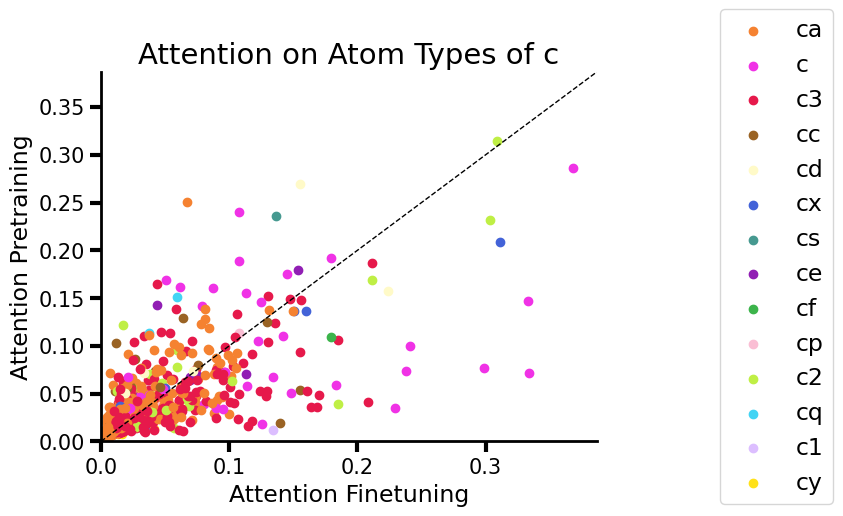

f


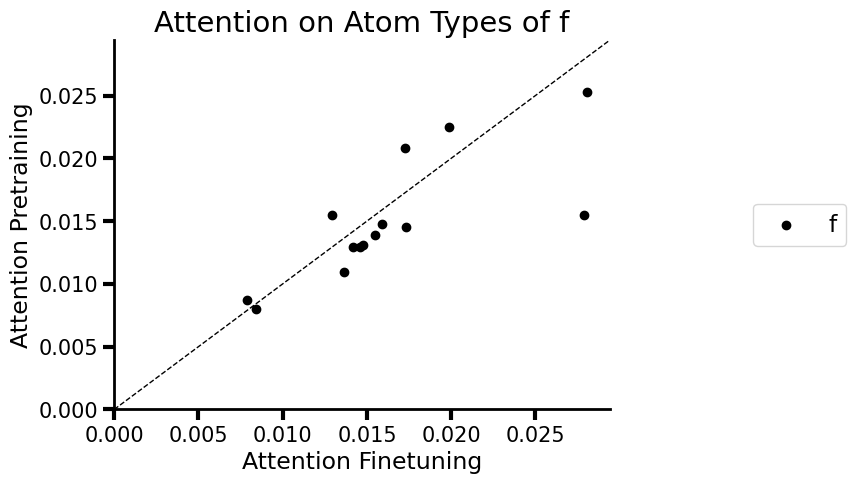

n
t-statistic: calculated as (a-b)/stderror
T-statistic: 0.12969786657894394, P-value: 0.897026297650942
Fail to reject the null hypothesis - suggest the means are not different
	Atom type: na with 13 values
	T-statistic: 0.9532931831209934, P-value: 0.3592501854118544
	Atom type: nb with 24 values
	T-statistic: 1.2538482615387503, P-value: 0.22249226954372597
	Atom type: n8 with 3 values
	T-statistic: -3.291285874315439, P-value: 0.0812255525255144
	Atom type: nt with 1 values
	T-statistic: nan, P-value: nan
	Atom type: nh with 3 values
	T-statistic: -4.191191289598942, P-value: 0.05248624940543808
	Atom type: ns with 30 values
	T-statistic: -5.025890136823603, P-value: 2.3604867536672647e-05
	Reject the null hypothesis - suggest the means are different
	-----> average score differs significantly!
	Atom type: n7 with 1 values
	T-statistic: nan, P-value: nan
	Atom type: n with 12 values
	T-statistic: -2.317837415459229, P-value: 0.04073267639642016
	Reject the null hypothesis - suggest

/home/ifender/miniconda3/envs/attentionviz2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3747: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ifender/miniconda3/envs/attentionviz2/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


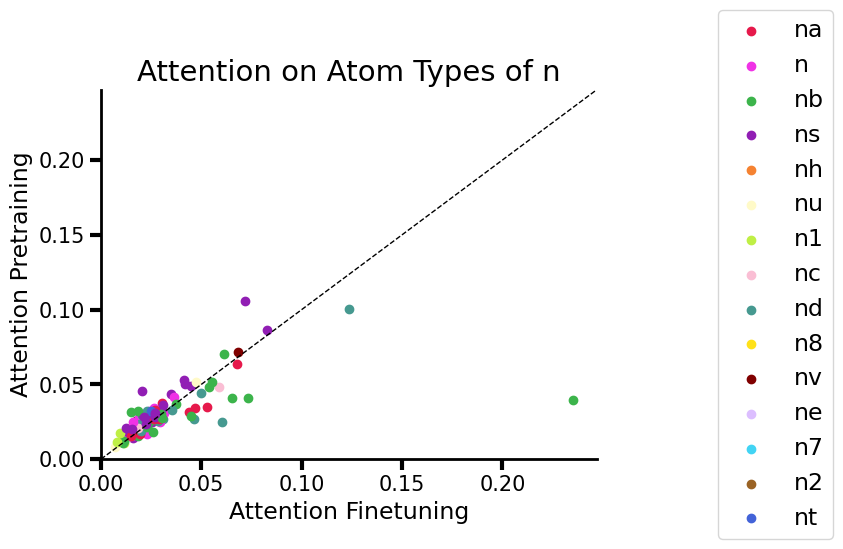

o
t-statistic: calculated as (a-b)/stderror
T-statistic: 1.6186677744809534, P-value: 0.10698476214278452
Fail to reject the null hypothesis - suggest the means are not different
	Atom type: os with 69 values
	T-statistic: 2.748817451241529, P-value: 0.007653175383795296
	Reject the null hypothesis - suggest the means are different
	-----> average score differs significantly!
	Atom type: op with 3 values
	T-statistic: -1.7148326460233567, P-value: 0.22851114948058243
	Atom type: oh with 63 values
	T-statistic: -1.7078283384385022, P-value: 0.09267130298373763
	Atom type: o with 81 values
	T-statistic: 0.20644698074576967, P-value: 0.836966292539657


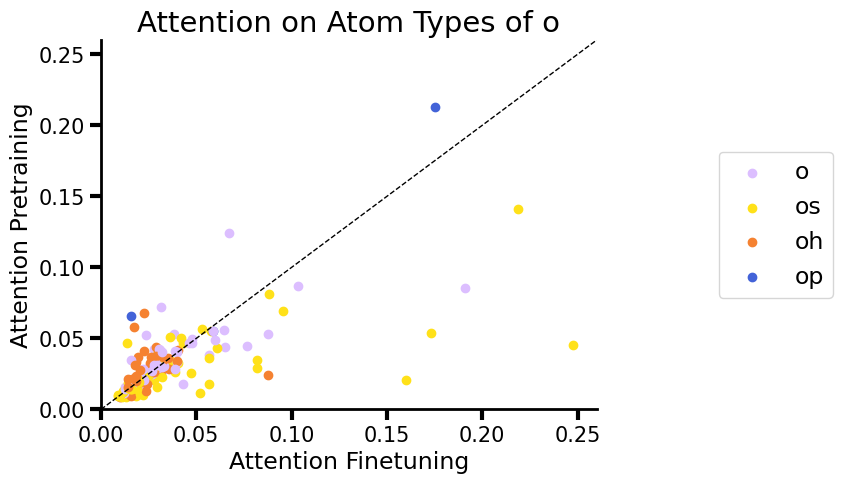

p
s


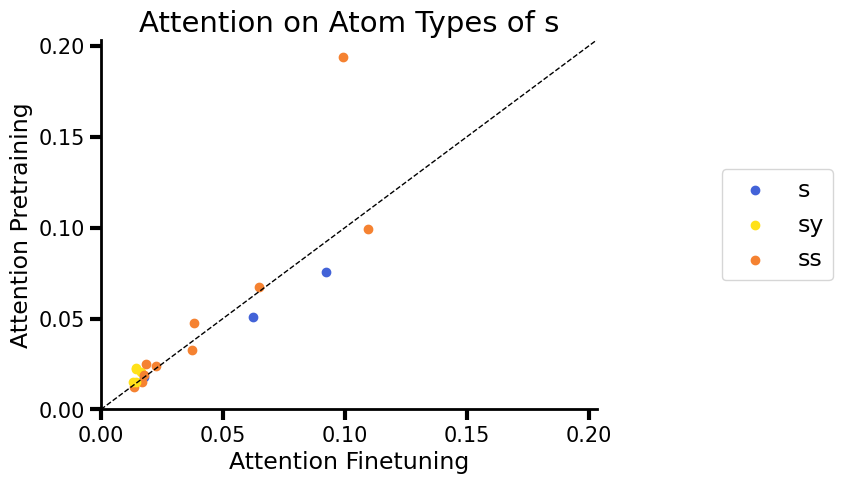

cl


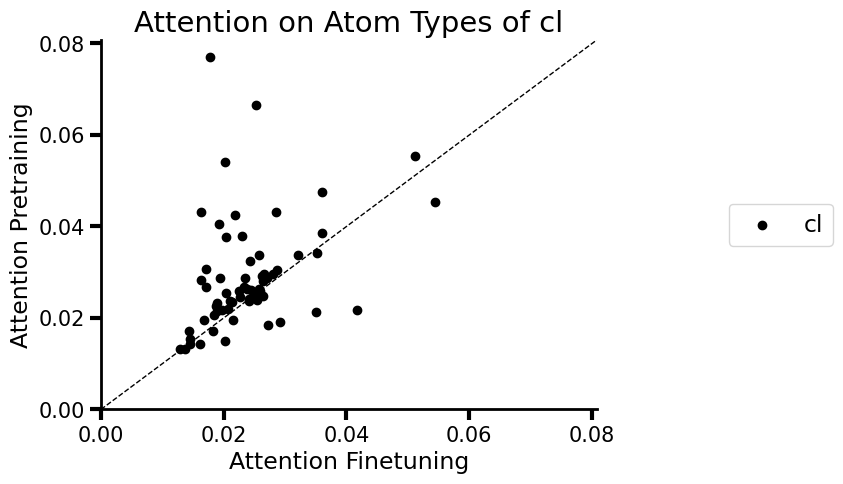

In [20]:
for key, val in plot_dict_per_elem.items():
   # print(key)
   # print(val['atomtype_lists'])
   # print(len(val['atomtype_lists']))
   # print(val['x_values'])
   # print(val['y_values'])
    print(key)
    plotter_atomtypes_vs_attention_pretrained_finetuned(val['atomtype_lists'],val['x_values'],val['y_values'],key,"notnormed",True)
    if key in ['c','n','o']:
         perform_paired_ttest(val['atomtype_lists'],val['x_values'],val['y_values'])
    plt.show()

In [41]:
# plot only subselection of atomtypes
atomtype_lists = []
x_values = []
y_values = []
for element, atomtypes in zip(['c c2 c3 ca'], [['c','c2','c3','ca']]):
    print(element,"and ",atomtypes)
    plot_dict_per_elem[element] = {}
    for key,val in dikt.items():
        print(key)
        print(val)
        if atts in val and val[atts] is not None:
            atomtype_to_atts_pre_fine = val[atts]
            for atomtype, values in atomtype_to_atts_pre_fine:
                print("\t",atomtype)
                if atomtype in atomtypes:
                    atomtype_lists.append(atomtype)
                    x_values.append(values[1]) #finetuned
                    y_values.append(values[0]) #pretrained
    assert len(atomtype_lists)==len(x_values)==len(y_values), "Assert failed"
    plot_dict_per_elem[element]['atomtype_lists'] = atomtype_lists
    plot_dict_per_elem[element]['x_values'] = x_values
    plot_dict_per_elem[element]['y_values'] = y_values

c c2 c3 ca and  ['c', 'c2', 'c3', 'ca']
c1cc2ccc3cccc4ccc(c1)c2c34
{'posToKeep': [0, 2, 3, 5, 6, 7, 9, 10, 11, 12, 14, 15, 16, 18, 21, 23], 'smi_clean': ['c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c'], 'atom_types': ['ca', 'ca', 'ca', 'ca', 'ca', 'ca', 'ca', 'ca', 'ca', 'ca', 'ca', 'ca', 'ca', 'ca', 'ca', 'ca'], 'max_penalty': 6.0, 'attention_bart_pretrained': {'raw_attention': array([0.01732512, 0.05493717, 0.0463205 , 0.07805961, 0.11321026,
       0.05226177, 0.04052735, 0.04309419, 0.03298041, 0.02633271,
       0.02514527, 0.02384851, 0.02334529, 0.02591144, 0.02311009,
       0.06307255, 0.03149052, 0.0381921 , 0.0223051 , 0.04946436,
       0.02806857, 0.02169168, 0.04377414, 0.0207397 , 0.02407987,
       0.03071172]), 'clean_attention': [0.01732512377202511, 0.04632049798965454, 0.0780596062541008, 0.05226176977157593, 0.0405273474752903, 0.04309419170022011, 0.026332708075642586, 0.0251452699303627, 0.023848513141274452, 0.02334529347717762, 0

dict_keys(['c', 'f', 'n', 'o', 'p', 's', 'cl', 'c c2 c3 ca'])
t-statistic: calculated as (a-b)/stderror
T-statistic: -2.020502474673396, P-value: 0.043548727340508166
Reject the null hypothesis - suggest the means are different
-----> average score differs significantly!
	Atom type: ca
	T-statistic: -9.024765168618801, P-value: 1.7115337527053428e-18
	Reject the null hypothesis - suggest the means are different
	-----> average score differs significantly!
	Atom type: c
	T-statistic: 1.7985665799053423, P-value: 0.07646096494408498
	Atom type: c3
	T-statistic: 1.037305478443495, P-value: 0.30019607720581093
	Atom type: c2
	T-statistic: 0.2752451674420335, P-value: 0.7847463349755984


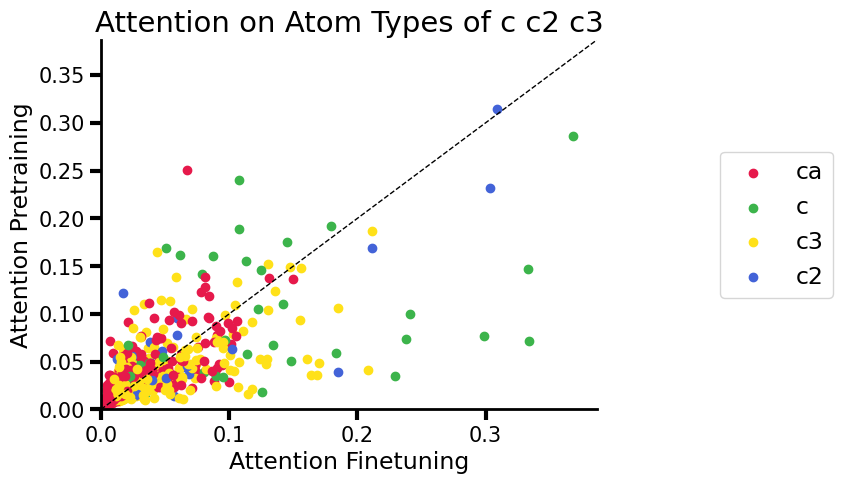

In [44]:
print(plot_dict_per_elem.keys())
plotter_atomtypes_vs_attention_pretrained_finetuned(plot_dict_per_elem['c c2 c3 ca']['atomtype_lists'],plot_dict_per_elem['c c2 c3 ca']['x_values'],plot_dict_per_elem['c c2 c3 ca']['y_values'],'c c2 c3',"notnormed",True)
perform_paired_ttest(plot_dict_per_elem['c c2 c3 ca']['atomtype_lists'],plot_dict_per_elem['c c2 c3 ca']['x_values'],plot_dict_per_elem['c c2 c3 ca']['y_values'])
#plt.savefig(f"./attention_prevsfine/c_c2_c3_ca_notnormed_attention_pretrained_finetuned.svg",bbox_inches='tight')

### Plot each element in a plot to compare pretrained vs finetuned attention NORMALISED on elements for Delaney

with minmax normalised attention the diagonal of attention from pretraining and finetuning gets lost

In [22]:
#decide here whether you want to see original attentions or normalised attentions
# normed to values 0-1
atts='atomtype_to_clean_minmaxnormed_atts_pre_fine'
# original
#atts='atomtype_to_clean_atts_pre_fine'
plot_dict_per_elem = {}


for element, atomtypes in elements_to_atomtypes.items():
    #print(element)
    atomtype_lists = []
    x_values = []
    y_values = []
    plot_dict_per_elem[element] = {}
    for key,val in dikt.items():
        #print(key)
        #print(val)
        if atts in val and val[atts] is not None:
            atomtype_to_atts_pre_fine = val[atts]
            for atomtype, values in atomtype_to_atts_pre_fine:
                #print("\t",atomtype)
                if atomtype in atomtypes:
                    atomtype_lists.append(atomtype)
                    x_values.append(values[1]) #finetuned
                    y_values.append(values[0]) #pretrained
    assert len(atomtype_lists)==len(x_values)==len(y_values), "Assert failed"
    plot_dict_per_elem[element]['atomtype_lists'] = atomtype_lists
    plot_dict_per_elem[element]['x_values'] = x_values
    plot_dict_per_elem[element]['y_values'] = y_values

c
t-statistic: calculated as (a-b)/stderror
T-statistic: -4.129248930820659, P-value: 3.866035644152122e-05
Reject the null hypothesis - suggest the means are different
-----> average score differs significantly!
	Atom type: cx with 18 values
	T-statistic: -2.9429716720417005, P-value: 0.009094255010423838
	Reject the null hypothesis - suggest the means are different
	-----> average score differs significantly!
	Atom type: ce with 15 values
	T-statistic: -0.2180938701947218, P-value: 0.8305029035378867
	Atom type: ca with 702 values
	T-statistic: -4.701411452980783, P-value: 3.11160308566242e-06
	Reject the null hypothesis - suggest the means are different
	-----> average score differs significantly!
	Atom type: c with 70 values
	T-statistic: 1.05871659489844, P-value: 0.2934211567102778
	Atom type: cd with 12 values
	T-statistic: -1.4294958157721618, P-value: 0.18064226532898325
	Atom type: cc with 23 values
	T-statistic: -1.1789903139891498, P-value: 0.25099617870055085
	Atom type: c

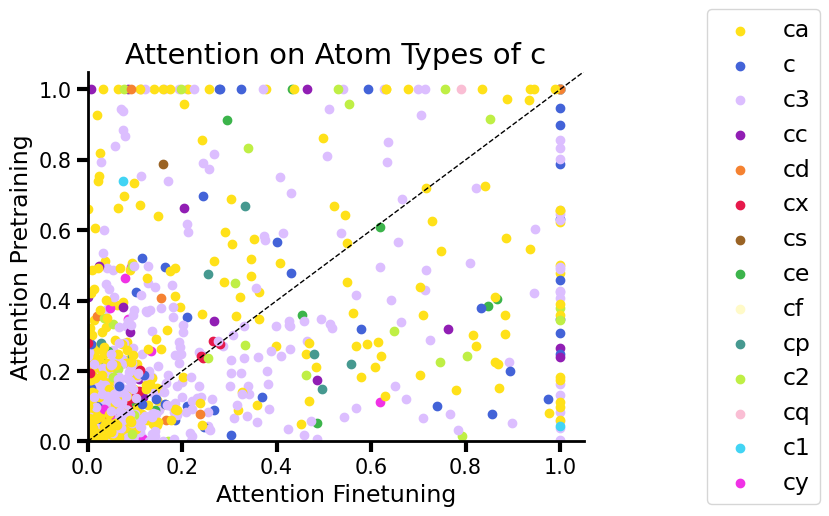

f


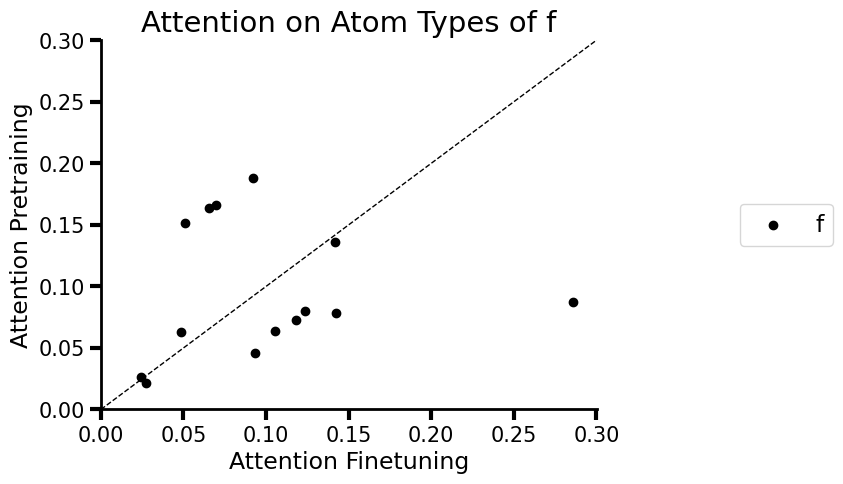

n
t-statistic: calculated as (a-b)/stderror
T-statistic: -1.3008745299095292, P-value: 0.19583601518727603
Fail to reject the null hypothesis - suggest the means are not different
	Atom type: nv with 5 values
	T-statistic: 0.19938848777011414, P-value: 0.8516844139640685
	Atom type: n with 12 values
	T-statistic: -1.9608074541403224, P-value: 0.07571010312326262
	Atom type: nb with 24 values
	T-statistic: 0.6298793425186306, P-value: 0.5349815195740911
	Atom type: nt with 1 values
	T-statistic: nan, P-value: nan
	Atom type: nc with 3 values
	T-statistic: -0.13949436238557103, P-value: 0.9018389555628901
	Atom type: ns with 30 values
	T-statistic: -1.9546137634710468, P-value: 0.06033028952373742
	Atom type: nd with 14 values
	T-statistic: 0.8603187910749036, P-value: 0.4052006539285328
	Atom type: n7 with 1 values
	T-statistic: nan, P-value: nan
	Atom type: ne with 2 values
	T-statistic: 0.5410855861998515, P-value: 0.6842535402452494
	Atom type: nh with 3 values
	T-statistic: -0.38614

/home/ifender/miniconda3/envs/attentionviz2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3747: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ifender/miniconda3/envs/attentionviz2/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


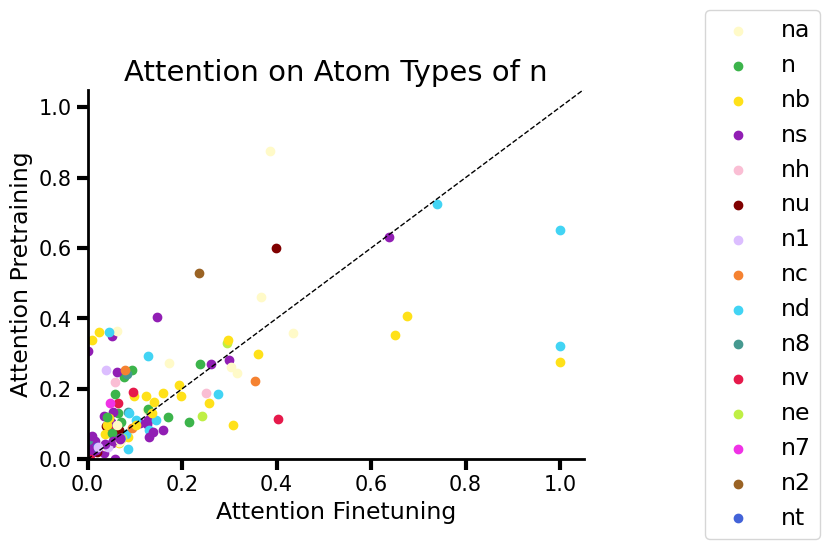

o
t-statistic: calculated as (a-b)/stderror
T-statistic: -1.0019507850851317, P-value: 0.317493687605904
Fail to reject the null hypothesis - suggest the means are not different
	Atom type: oh with 63 values
	T-statistic: -2.648885777405774, P-value: 0.010230736960809263
	Reject the null hypothesis - suggest the means are different
	-----> average score differs significantly!
	Atom type: os with 69 values
	T-statistic: 1.473224453281608, P-value: 0.1453046182256273
	Atom type: op with 3 values
	T-statistic: -1.9195436477458165, P-value: 0.19490670465297563
	Atom type: o with 81 values
	T-statistic: -0.2656894407588519, P-value: 0.7911618877983592


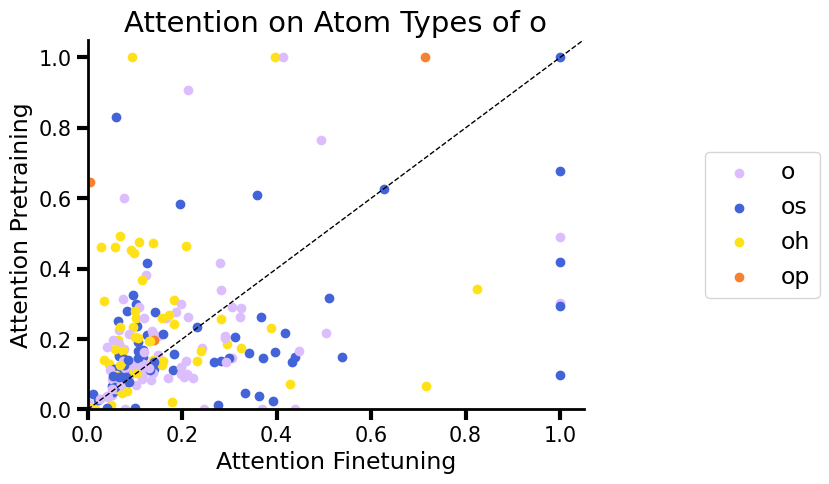

p
s


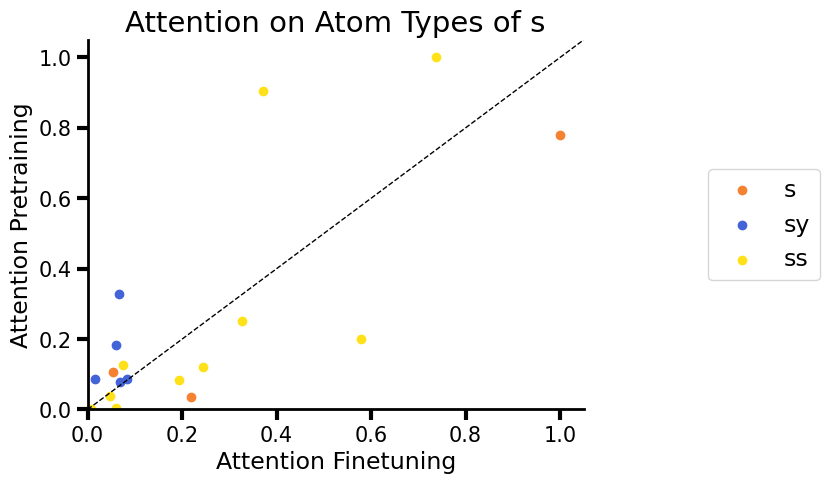

cl


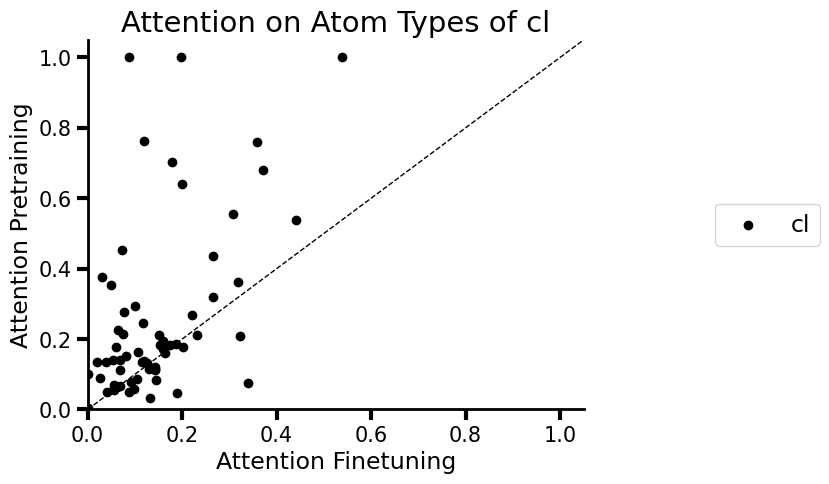

In [23]:
for key, val in plot_dict_per_elem.items():
   # print(key)
   # print(val['atomtype_lists'])
   # print(len(val['atomtype_lists']))
   # print(val['x_values'])
   # print(val['y_values'])
    print(key)
    plotter_atomtypes_vs_attention_pretrained_finetuned(val['atomtype_lists'],val['x_values'],val['y_values'],key,"notnormed",True)
    if key in ['c','n','o']:
         perform_paired_ttest(val['atomtype_lists'],val['x_values'],val['y_values'])
    plt.show()